# CI Portfolio Project 5 - Filter Maintenance Predictor 2022
## **Feature Engineering Notebook**

## Objectives

**1. Cleaning**

Performed within the [data cleaning notebook](https://github.com/roeszler/filter-maintenance-predictor/blob/main/jupyter_notebooks/02_DataCleaning.ipynb).

**2. Data Transformation**
* Processing the data for the modelling stage.
* Transform data into a format that is useful for the algorithm learn the relationship among the variables.
* Evaluate the use of the following approaches to engineer the variables:
    * ordinal categorical encoding
    * numerical transformation
    * smart correlated selection
    
**3. Feature Extraction**
* Evenly distribute dust type

**4. Feature Selection**

**5. Feature Iteration**



### Inputs

1. Cleaned Test Dataset : `outputs/datasets/collection/dfCleanTrain.csv`

2. Cleaned Train Dataset : `outputs/datasets/collection/dfCleanTrain.csv`

### Outputs

* Generate engineered Train and Test sets, both saved under `outputs/datasets/transformed`

### Conclusions

  * Best approach to engineer variables based on...
  * Transformations that we will consider in our pipeline are...

---

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/filter-maintenance-predictor/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("Current directory set to new location")

Current directory set to new location


In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/filter-maintenance-predictor'

---

# Load Cleaned Data

In [4]:
import pandas as pd
df_total = pd.read_csv(f'outputs/datasets/cleaned/dfCleanTotal.csv')

---

# Data Transformation
## Feature Extraction

It is important to define
* Feature Extraction: **creates** new features from functions of the original features.
* Feature Selection: allows us to **choose** a subset of the features for use in model construction.

Semantically we could argue each are a **new feature** or a **subset** of the feature. We have however considered any value intended for use in model construction as a **Selected Feature**: *The process of selecting a subset of relevant features (variables, predictors) for use in model construction*. 

Feature selection techniques are used for several reasons:

* Simplification of models to make them easier to interpret by researchers/users
* Shorter training times
* Avoiding too many input variables (dimensionality)
* Improve the data's compatibility with a learning model class
* Create symmetries in the input data.

The main idea when using a feature selection is that the data contains some features that are either **surplus**, **redundant** or **irrelevant** to the final business goal and can therefore be removed without incurring much loss of predictive power.

## Ordinal Categorical encoding

#### Replacing categories with ordinal numbers 
The dataset as two categorical features, **Data_No** and **Dust**.

These have been been transformed in the **01_DataCollection** notebook to assist us with the manipulation of the data.  They are in the format we desire at this point. We may need to transform these back into their respective categorical values, however this won't be performed until required.

In [5]:
# data_no_total = df_total['Data_No'].map(str)
# df_total['Data_No'] = data_no_total
# df_total.info()

## Numerical transformations

This process can consider transformers like:
* Smooth with SMA
* Logarithmic in base e
* Logarithmic in base 10
* Reciprocal
* Power
* BoxCox
* Yeo Johnson

The dataset has several numerical features to assess. A [custom function](https://github.com/Code-Institute-Solutions/churnometer/blob/main/jupyter_notebooks/04%20-%20FeatureEngineering.ipynb) found at the [code institute] has been included as a quick way to represent the data for evaluation. Including the full report into this notebook made it a little unwieldy. It has been included as an addendum notebook at [04_FeatEngAddendum.ipynb](https://github.com/roeszler/filter-maintenance-predictor/blob/main/jupyter_notebooks/03A_FeatEngAddendum.ipynb) optionally for your review. 

**In summary**, it reveals:
* BoxCox and Yeo Johnson for most variables improve `Time` and `Differential Pressure` features, however the existence of negative **differential pressure** values present a challenge to log transform this data.
* Due to the [value of log transformation](https://stats.stackexchange.com/questions/107610/what-is-the-reason-the-log-transformation-is-used-with-right-skewed-distribution) to regression models, the following notebook follows a modification and filtering of the data to remove negative values and apply a log transformation. 
* Notwithstanding, a **Modified Log Transformed**, **BoxCox** and **Yeo Johnson** will be considered at each modelling stage to evaluate their effects on model performance. 

## Change in Differential Pressure
Include change in Differential Pressure calculation

**Note**: We replace first instance of `change_DP` with first value of `differential_pressure` in the new bin. 
* This signifies that the fist observation starts from a **zero** DP value.

In [6]:
df_change_dp = pd.DataFrame()

list_data_nos = list(df_total['Data_No'].unique())
for n in list_data_nos:
    if (df_total.Data_No != df_total.Data_No.shift(1)).any().any():
        df_bin = df_total[df_total['Data_No'] == n]

        change_dp_calc = df_bin['Differential_pressure'].diff().fillna(df_bin['Differential_pressure'])
        df_bin.insert(loc=7, column='change_DP', value=change_dp_calc)

        df_change_dp = pd.concat([df_change_dp, df_bin], ignore_index = True)
df_total = df_change_dp
df_total.loc[446:451]

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,mass_g,cumulative_mass_g,Tt,filter_balance
446,1,230.486800,55.070987,44.7,236.428943,1.025,NaN,2.531800,0.24234,108.325831,44.9,61.59
447,1,227.955000,55.052254,44.8,236.428943,1.025,NaN,-2.531800,0.24234,108.568171,44.9,62.01
448,1,227.955000,55.305573,44.9,236.428943,1.025,NaN,0.000000,0.24234,108.810510,44.9,62.01
449,2,0.994647,53.225440,0.1,236.428943,1.025,NaN,0.994647,0.24234,0.242340,44.9,99.83
450,2,0.542535,55.080360,0.2,236.428943,1.025,NaN,-0.452112,0.24234,0.484679,44.9,99.91
451,2,1.085069,56.179876,0.3,236.428943,1.025,NaN,0.542534,0.24234,0.727019,44.9,99.82


**Note**: Part of the challenge with this data is dealing with a continuous dataset that is comprised of data 'bins'. Each `Data_No` data bin represents an individual test cycle. 

When engineering **descriptive statistics** into the dataset, that typically used a sample of the previous values to indicate a mean or standard deviation, **we need to treat each bin individually** and not progress the first row of each bin incorrectly with the last rows of the previous bin.

To solve this, we use a sequential loop that proceeds through each bin and inserts a progressive descriptive statistic calculation like change in differential pressure (`change_DP`) and appends it to the previous bin. This eventually creates a version of the dataset that includes the new calculation.

### Outliers in differential pressure observations

In each bin we notice that the size and direction of the `change_DP` measure occasionally produces a zero or negative value. This highlights a fluctuation in the **differential pressures**. These may be considered outliers as the pressure gradient across the filter needs time to stabilize. We have considered three main methods to deal with these observations:
* Log transformation
* Winsorize method
* Dropping the outliers

These will be handled in the [feature engineering](https://github.com/roeszler/filter-maintenance-predictor/blob/main/jupyter_notebooks/03_FeatureEngineering.ipynb) notebook

**Random sample** (Bin 96) to plot and inspect change in Differential Pressure distributions

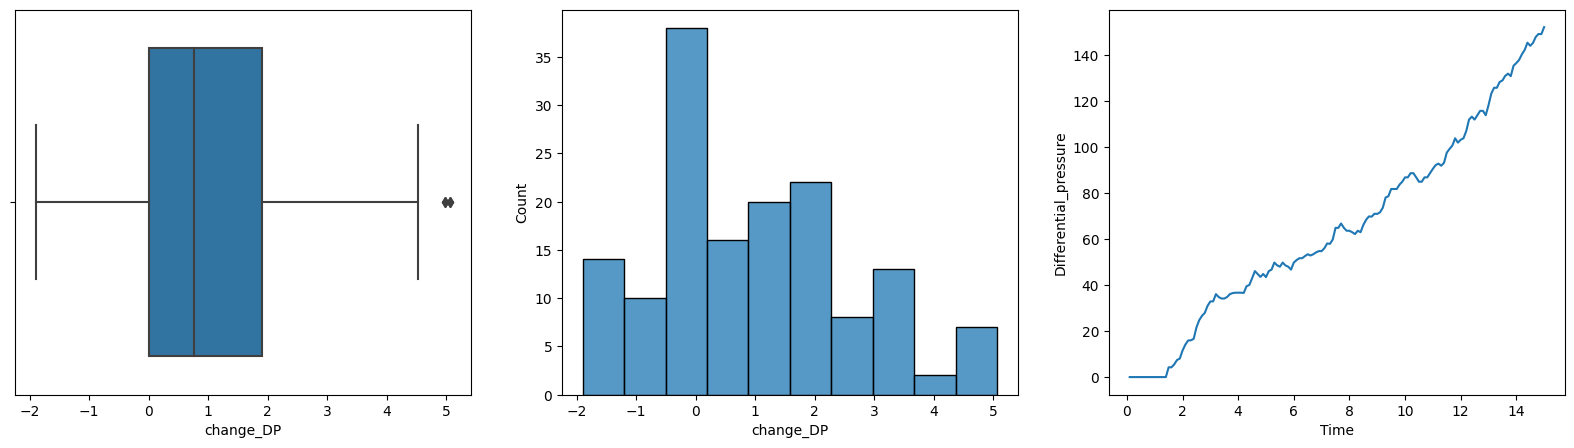

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))

bin_96 = df_total[df_total['Data_No'] == 96]
sns.boxplot(x = bin_96['change_DP'], ax=ax1)
sns.histplot(x = bin_96['change_DP'], ax=ax2)
sns.lineplot(x=bin_96['Time'], y=bin_96['Differential_pressure'], ax=ax3)
plt.show()

## Smoothing of **Differential Pressure**
*Dealing with outliers in differential pressure observations*

In each bin note `differential_pressure` and `change_DP` observations. Occasionally the measures fluctuate outside of the general trend of the data (outliers). This can be seen below in the **second to last** observation of Data_No bin 98 (index no. 75826) where the recorded value is outside the general trend of the data. 

In [8]:
df_total[df_total['Data_No'] == 98].tail()

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,mass_g,cumulative_mass_g,Tt,filter_balance
75823,98,231.1198,58.831609,28.3,316.985065,0.9,13.9,2.2606,0.285287,80.450810,28.7,61.48
75824,98,231.6623,59.295392,28.4,316.985065,0.9,13.8,0.5425,0.285287,80.736096,28.7,61.39
75825,98,231.9336,58.842588,28.5,316.985065,0.9,13.7,0.2713,0.285287,81.021383,28.7,61.34
75826,98,236.3643,58.842588,28.6,316.985065,0.9,13.6,4.4307,0.285287,81.306669,28.7,60.61
75827,98,231.8432,58.853552,28.7,316.985065,0.9,13.5,-4.5211,0.285287,81.591956,28.7,61.36


<!-- To quantify such measures, have considered a tolerance of ±200% change in value, however this can be altered depending on what we see when fitting the models. -->

To **smooth** the variability of this measure we can apply a **mean** (or average) value to the data in various ways. 
This attempts to soften the severity of changes seen and reduce the instances of values that are higher / lower than the general trend. It will effectively reduce variability in the **differential pressure** measure, making it easier to model.

We have considered the following methods to deal with outliers:
* Smooth with Simple Mean Average (SMA)
* Exponentially Weighted Mean (EWM)
* Log transformation
* Dropping the outliers
* Winsorize method

For each calculation that uses previous observations to produce a value, we can **use the same process we applied to manage the unique data bins** as we did in calculating change in differential pressure above.

#### Smoothing of Differential Pressure with a **Simple Moving Average** (SMA)
A simple moving average (SMA) is an arithmetic **moving average** calculated by adding recent values (the last four measures in this case), then dividing that by the number of observations in the calculation. This moves along as the observations progresses.

* We can see the first four observations are **NaN** indicated. 
    * These could be imputed with arbitrary values, mean values, closest k sample values and/or a MICE (Multiple Imputation by Chained Equations) value that fits a linear regression with the present values.
    * On review, the MICE method would be the preferred method to impute the missing SMA values, **however**: considering the progressive nature of the `differential_pressure` variable, a preferable alternate to SMA would be Exponentially Weighted Mean (EWM).

#### Smoothing of Differential Pressure with an **Exponentially Weighted Mean** (EWM)
Is a measure of the moving average that considers older observations to have given lower weightings in the calculation. The weights fall exponentially as the data point gets older – hence the name exponentially weighted.

* The EWM is calculated with a 4 point EWM (`span=4`) measure, that considers the previous 4 observations to calculate the weighted mean.


In [9]:
df_means = pd.DataFrame()

list_data_nos = list(df_total['Data_No'].unique())
for n in list_data_nos:
    if (df_total.Data_No != df_total.Data_No.shift(1)).any().any():
        df_bin = df_total[df_total['Data_No'] == n]

        ewm_calc = df_bin['Differential_pressure'].ewm(span=4, adjust=False).mean()
        df_bin.insert(loc=2, column='4point_EWM', value=ewm_calc)

        sma_calc = df_bin['Differential_pressure'].rolling(4).mean()
        df_bin.insert(loc=2, column='4point_SMA', value=sma_calc)

        change_ewm_calc = df_bin['4point_EWM'].diff().fillna(df_bin['4point_EWM'])
        df_bin.insert(loc=10, column='change_EWM', value=change_ewm_calc)

        df_means = pd.concat([df_means, df_bin], ignore_index = True)
df_total = df_means
df_total.loc[446:451]

,Data_No,Differential_pressure,4point_SMA,4point_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
446,1,230.486800,227.661125,227.059478,55.070987,44.7,236.428943,1.025,NaN,2.531800,2.284881,0.24234,108.325831,44.9,61.59
447,1,227.955000,228.610550,227.417687,55.052254,44.8,236.428943,1.025,NaN,-2.531800,0.358209,0.24234,108.568171,44.9,62.01
448,1,227.955000,228.587950,227.632612,55.305573,44.9,236.428943,1.025,NaN,0.000000,0.214925,0.24234,108.810510,44.9,62.01
449,2,0.994647,NaN,0.994647,53.225440,0.1,236.428943,1.025,NaN,0.994647,0.994647,0.24234,0.242340,44.9,99.83
450,2,0.542535,NaN,0.813802,55.080360,0.2,236.428943,1.025,NaN,-0.452112,-0.180845,0.24234,0.484679,44.9,99.91
451,2,1.085069,NaN,0.922309,56.179876,0.3,236.428943,1.025,NaN,0.542534,0.108507,0.24234,0.727019,44.9,99.82


## **Logarithmic Transformation** of Differential Pressure

As seen at data collection, the original continuous `differential_pressure` data is right or **positively skewed** at 1.81 and does not follow the shape of a normally distributed bell curve.
* Included a plot for both instances of the **moving average smoothed** variable to check that it is representative of the **differential_pressure** source, which it is.


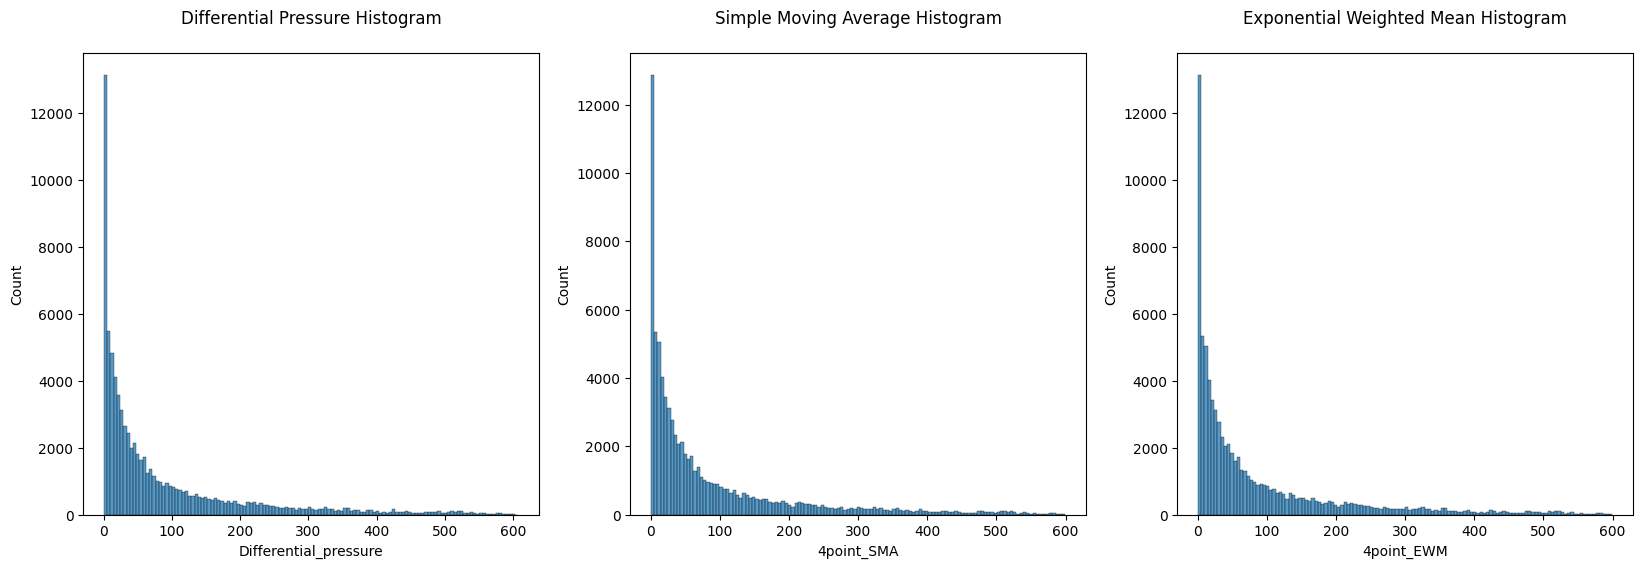

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,6))

sns.histplot(x = df_total['Differential_pressure'], ax=ax1)
sns.histplot(x = df_total['4point_SMA'], ax=ax2)
sns.histplot(x = df_total['4point_EWM'], ax=ax3)

ax1.title.set_text('Differential Pressure Histogram\n')
ax2.title.set_text('Simple Moving Average Histogram\n')
ax3.title.set_text('Exponential Weighted Mean Histogram\n')
plt.show()

A **log transformation** of this data will represent the values within a normal distribution, **as much as possible**, allowing a more valid statistical analysis from this data.

/workspace/.pip-modules/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/workspace/.pip-modules/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/workspace/.pip-modules/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


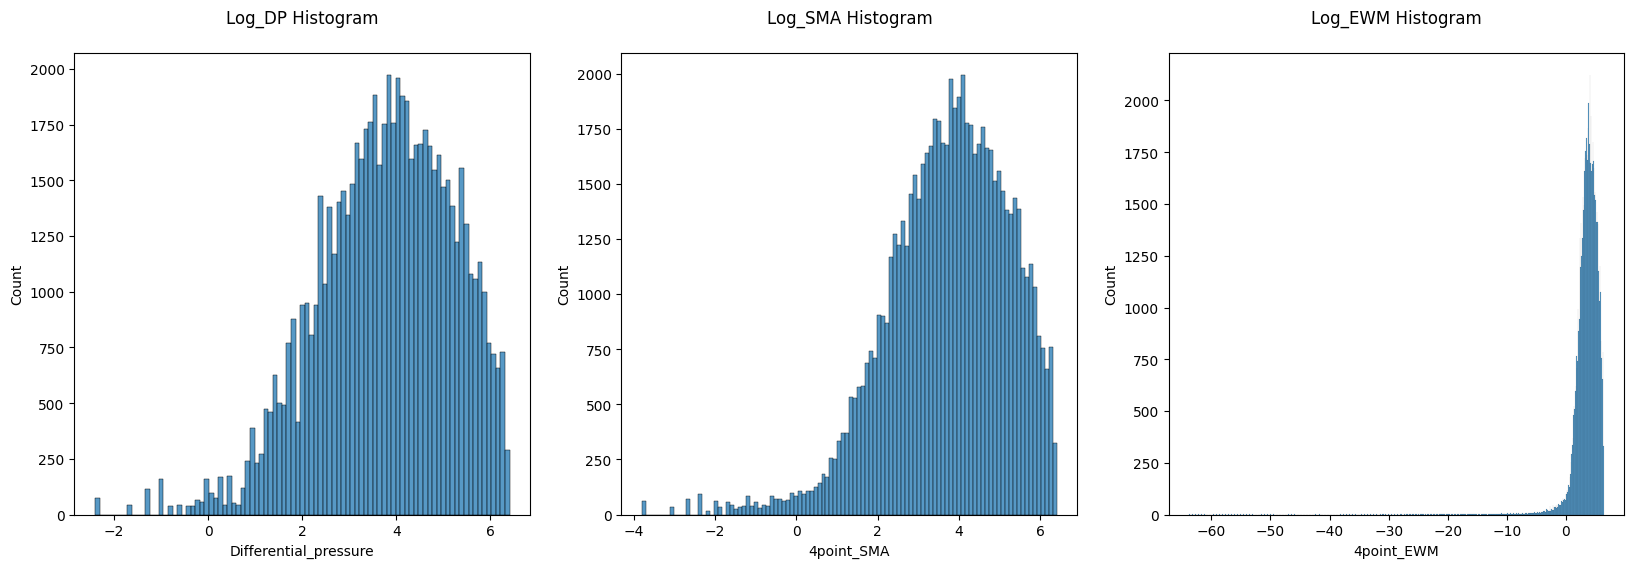

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,6))

df_total_log_dp = df_total['Differential_pressure']
log_dp = np.log(df_total_log_dp)
sns.histplot(x = log_dp, ax=ax1)

df_total_log_sma = df_total['4point_SMA']
log_sma = np.log(df_total_log_sma)
sns.histplot(x = log_sma, ax=ax2)

df_total_log_ewm = df_total['4point_EWM']
log_ewm = np.log(df_total_log_ewm)
sns.histplot(x = log_ewm, ax=ax3)

# plt.title('Log Histogram')
ax1.title.set_text('Log_DP Histogram\n')
ax2.title.set_text('Log_SMA Histogram\n')
ax3.title.set_text('Log_EWM Histogram\n')
plt.show()

**Observations** 
* The shape of the numerical differential pressure data is **improved** by a natural logarithmic transformation.
    <!-- * Untreated values of 85.71 mean, std.deviation at 114.34 and median at 38.34, indicates the positively skewed nature of the original data
    * Transformed the data is much improved with mean 3.18 much closer to the median 3.89 -->

The transformed data is still affected by the negative skew in the data:
* Pressure measures show values at zero or below at the beginning and tail of the data. This is amplified when we transform the mean data sets.
    * The instances of negative numbers can be managed by:
        * Adding a constant to stop the value becoming negative, or 
        * Indicate the negative as a missing number or 
        * Dropping the entire observation
    * Considering these measures tend to fall in zones at the beginning or end of the test where the procedure takes a while to 'equalize' or has passed the point of filter failure, we have decided to treat them as outliers and confidently drop the entire row these observation sits within without impacting the power of the models.

In [12]:
# df = pd.DataFrame()
# df.insert(loc=0, column='log_EWM', value=(log_ewm*10))
# df.insert(loc=0, column='log_SMA', value=(log_sma*10))
# df.insert(loc=0, column='log_DP', value=(log_dp*10))
# df.insert(loc=0, column='DP', value=df_total_log_dp)
# round(df.describe(), 2)

**Further EWM transformation**

Remove rows with negative numbers in `4pointWEM` column

In [13]:
# df_total.insert(loc=4, column='log_EWM', value=log_ewm)
# data = df_total.loc[:, df_total.columns == 'log_EWM']
# df_total = df_total[data.select_dtypes(include=[np.number]).ge(-0).all(1)]
# # df_total

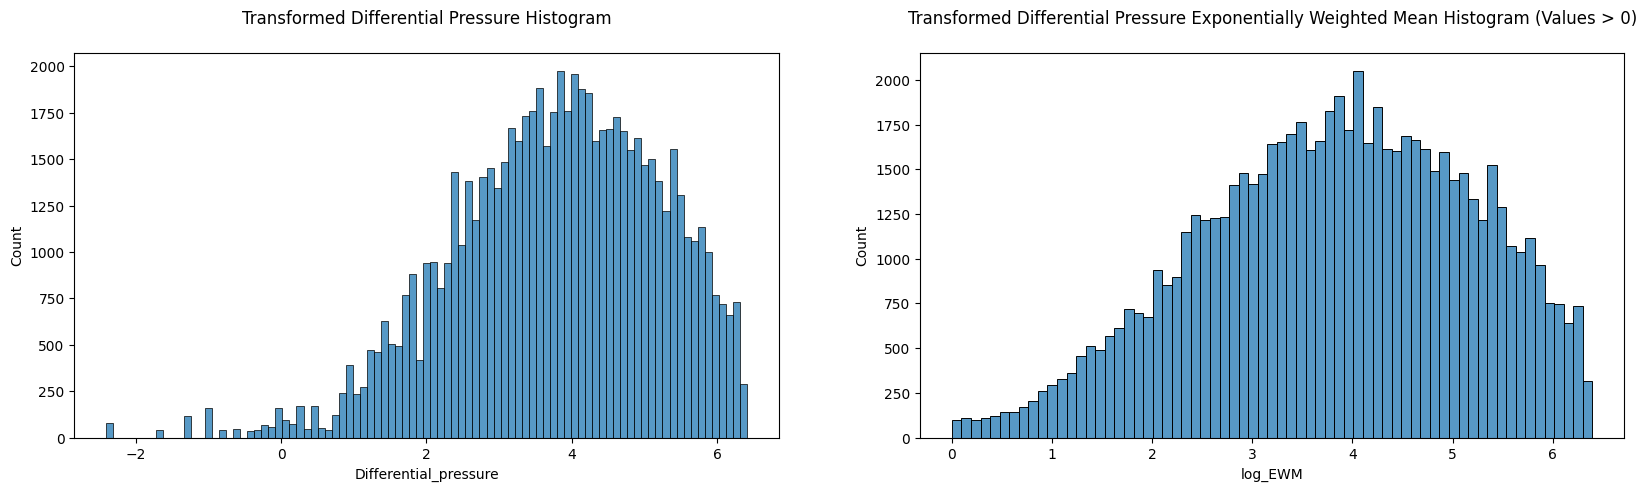

Old Shape:  (78834, 11)
New Shape:  (69686, 16)


In [14]:
# Remove Negative values
df_total.insert(loc=4, column='log_EWM', value=log_ewm)
data = df_total.loc[:, df_total.columns == 'log_EWM']
df_total = df_total[data.select_dtypes(include=[np.number]).ge(-0).all(1)]

# Visualize the data
old_shape = pd.read_csv(f'outputs/datasets/cleaned/dfCleanTotal.csv')
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))

sns.histplot(x = log_dp, ax=ax1)
sns.histplot(x = df_total['log_EWM'], ax=ax2)

plt.title('log_EWM Histogram')
ax1.title.set_text('Transformed Differential Pressure Histogram\n')
ax2.title.set_text('Transformed Differential Pressure Exponentially Weighted Mean Histogram (Values > 0)\n')
plt.show()
print("Old Shape: ", old_shape.shape)
print("New Shape: ", df_total.shape)

This transformed data is far more useable to train the model. 
* Less variability 
* Negative values removed
* Minimal loss of data

### Further Management of Outliers
Dropping all negative numbers to reduce the noise of the data

#### Evaluation of detecting outliers using **Inter Quartile Range** (IQR).

Old Shape:  (69686, 16)
New Shape:  (69686, 16)


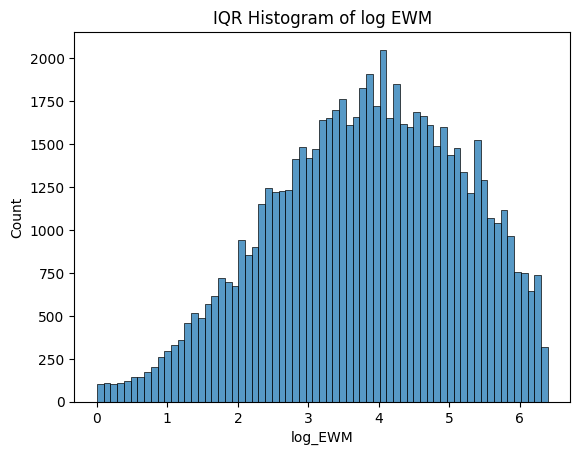

In [15]:
df_total_IQR = df_total.copy()

# IQR
Q1 = np.percentile(df_total_IQR, 25, method='midpoint')
Q3 = np.percentile(df_total_IQR, 75,method='midpoint')
IQR = Q3 - Q1
print("Old Shape: ", df_total_IQR.shape)
 
# Upper bound
upper = np.where(df_total_IQR >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df_total_IQR <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
df_total_IQR.drop(upper[0], inplace = True)
df_total_IQR.drop(lower[0], inplace = True)
 
print("New Shape: ", df_total_IQR.shape)

# df_total_log_IQR = df_total_IQR['Differential_pressure']
# df_total_log_IQR = df_total_IQR['4point_SMA']
# df_total_log_IQR = df_total_IQR['4point_EWM']
df_total_log_IQR = df_total_IQR['log_EWM']
log_dp_IQR = np.log(df_total_log_IQR)
# df_total_IQR['log_DP'] = log_dp
sns.histplot(x = df_total_log_IQR)
plt.title('IQR Histogram of log EWM')
plt.show()

IQR transformation is not particularly effective on this data with negative values removed. We will not apply this method and proceed with other techniques.

#### **The Winsorize Method**
Winsorization is the process of replacing the extreme values of statistical data in order to limit the effect of the outliers on the calculations or the results obtained by using that data. To apply this to a our exponentially logged differential pressure `log_EWM` variable, where outliers are present only at one end of the data:
* The lower 10% values of the data will have their values set equal to the value of the data point at the 10th percentile.

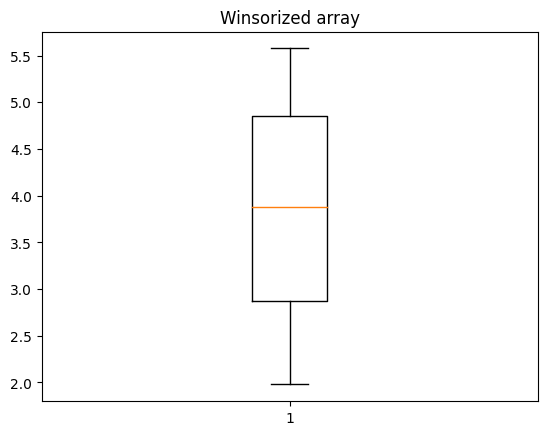

Old Mean:  3.8140198177644837
New Mean:  3.8430543225205263


In [16]:
from scipy.stats.mstats import winsorize

WinsorizedArrayMean = np.mean(df_total['log_EWM'])
winz_EWM = winsorize(df_total['log_EWM'],(0.1,0.1))
df_total.insert(loc=5, column='winz_EWM', value=winz_EWM)
WinsorizedArray = df_total['winz_EWM']
plt.boxplot(WinsorizedArray)
plt.title('Winsorized array')
plt.show()
WinsorizedArrayNewMean = np.mean(WinsorizedArray)
print('Old Mean: ', WinsorizedArrayMean)
print('New Mean: ', WinsorizedArrayNewMean)

<AxesSubplot: xlabel='winz_EWM', ylabel='Count'>

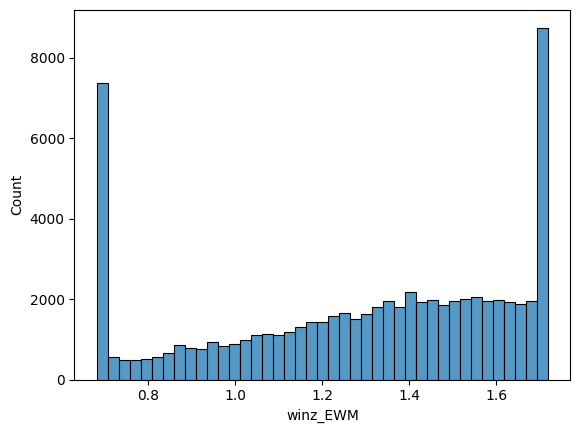

In [17]:
df_total_log_winz = df_total['winz_EWM']
log_winz = np.log(df_total_log_winz)
sns.histplot(x = log_winz)

Winzorization smooths the data too much and does not add much value to training our models so we will not apply this method either. 

In [18]:
del df_total['winz_EWM']
del df_total['4point_SMA']
# del df_train['winz_Mean']
# del df_train['log_DP']
df_total

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
54,1,1.537182,1.046296,0.045257,54.143527,5.5,236.428943,1.025,NaN,0.000000,0.327257,0.242340,13.328682,44.9,99.74
55,1,1.537182,1.242651,0.217247,54.518255,5.6,236.428943,1.025,NaN,0.000000,0.196354,0.242340,13.571021,44.9,99.74
56,1,1.537182,1.360463,0.307825,54.658781,5.7,236.428943,1.025,NaN,0.000000,0.117813,0.242340,13.813361,44.9,99.74
57,1,3.345631,2.154530,0.767573,54.780562,5.8,236.428943,1.025,NaN,1.808449,0.794067,0.242340,14.055701,44.9,99.44
58,1,5.244502,3.390519,1.220983,54.574466,5.9,236.428943,1.025,NaN,1.898871,1.235989,0.242340,14.298040,44.9,99.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78829,100,465.494800,457.888170,6.126625,82.675521,52.0,316.985065,1.200,8.2,6.329500,5.071087,0.380382,197.798681,52.4,22.42
78830,100,464.228900,460.424462,6.132149,82.421873,52.1,316.985065,1.200,8.1,-1.265900,2.536292,0.380382,198.179063,52.4,22.63
78831,100,466.037300,462.669597,6.137013,82.743156,52.2,316.985065,1.200,8.0,1.808400,2.245135,0.380382,198.559445,52.4,22.33
78832,100,472.276500,466.512358,6.145285,82.785427,52.3,316.985065,1.200,7.9,6.239200,3.842761,0.380382,198.939827,52.4,21.29


## Evenly distribute dataset by `Dust` type

Both the **train** and **test** sets supplied have data distributed unevenly between 50 test bins. To account for this we wish to assess the measures of central tendency for each Dust class, with the aim of reducing the data size to a more evenly proportioned one between classes.

#### **Train** Dataset

**Considerations**

* The proportion of data that **has reached filter failure** is represented by how close `filter_balance` is to zero or less. 
    * Data with filter_balance values approaching zero may be worth keeping and will make part of our heuristic decision process.
* Notwithstanding that the **mean** is the most frequently used measure of central tendency because it uses all values in the data set to give you an average
    * For data from skewed distributions (like `differential_pressure`), the **median** is better than the mean because it isn’t influenced by extremely large values.

In the following calculation, we see a summary of the top ten `Data_No` bins where `differential_pressure` observations that have made it to the **600 Pa** (the point of filter failure).

Divide back into **Train** and **Test** sets

In [19]:
data_no_total = df_total['Data_No'].map(int).round(decimals=0)
df_total.loc[:, 'Data_No'] = data_no_total

n = df_total['Data_No'].iloc[0:len(df_total)]
df_train = df_total[n < 51].reset_index(drop=True, names='index')
df_test = df_total[n > 50].reset_index(drop=True, names='index')
del df_train['RUL']
df_test

/tmp/ipykernel_926/1534207469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total.loc[:, 'Data_No'] = data_no_total


,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
0,51,2.622251,1.159577,0.148056,55.524146,0.4,236.428943,1.025,58.6,2.622251,0.975116,0.242340,0.969359,36.6,99.56
1,51,3.888165,2.251012,0.811380,55.852018,0.5,236.428943,1.025,58.5,1.265914,1.091435,0.242340,1.211698,36.6,99.35
2,51,4.521122,3.159056,1.150273,56.130203,0.6,236.428943,1.025,58.4,0.632957,0.908044,0.242340,1.454038,36.6,99.25
3,51,4.521122,3.703883,1.309382,56.150070,0.7,236.428943,1.025,58.3,0.000000,0.544826,0.242340,1.696378,36.6,99.25
4,51,4.521122,4.030778,1.393959,56.090457,0.8,236.428943,1.025,58.2,0.000000,0.326896,0.242340,1.938717,36.6,99.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36357,100,465.494800,457.888170,6.126625,82.675521,52.0,316.985065,1.200,8.2,6.329500,5.071087,0.380382,197.798681,52.4,22.42
36358,100,464.228900,460.424462,6.132149,82.421873,52.1,316.985065,1.200,8.1,-1.265900,2.536292,0.380382,198.179063,52.4,22.63
36359,100,466.037300,462.669597,6.137013,82.743156,52.2,316.985065,1.200,8.0,1.808400,2.245135,0.380382,198.559445,52.4,22.33
36360,100,472.276500,466.512358,6.145285,82.785427,52.3,316.985065,1.200,7.9,6.239200,3.842761,0.380382,198.939827,52.4,21.29


In [20]:
last_row_train = df_train[df_train.Data_No != df_train.Data_No.shift(-1)]
# last_row_descending = last_row_train.sort_values(by='Dust', ascending=True)
last_row_descending = last_row_train.sort_values(by='Differential_pressure', ascending=False)
last_row_descending.head(n=10)

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
31415,46,607.9102,595.680737,6.389705,83.219026,62.6,118.214472,0.900,11.8454,8.152975,0.106393,66.602033,62.6,-1.32
9443,11,604.9262,594.434824,6.387611,57.767143,62.3,158.492533,0.900,8.1380,6.994251,0.142643,88.866763,62.3,-0.82
29440,43,601.0380,598.488796,6.394408,81.534117,102.2,79.246266,0.900,4.3402,1.699469,0.071322,72.890716,102.2,-0.17
30084,44,600.9476,599.817209,6.396625,82.954522,65.6,158.492533,0.900,1.1754,0.753594,0.142643,93.573991,65.6,-0.16
32283,47,600.2242,597.957161,6.393519,59.281707,104.6,79.246266,0.900,0.5425,1.511359,0.071322,74.602435,104.6,-0.04
7501,8,589.1927,587.561629,6.375981,80.416409,179.4,59.107236,0.900,1.2659,1.087381,0.053197,95.434543,179.4,1.80
11421,14,477.3401,475.998323,6.165414,82.565603,66.9,158.492533,1.025,-1.2659,0.894518,0.162455,108.682292,66.9,20.44
20105,28,471.1010,468.419097,6.149363,82.751615,59.8,177.321707,1.025,3.1648,1.787935,0.181755,108.689341,157.2,21.48
13952,18,393.5185,392.617426,5.972836,82.202049,66.9,158.492533,1.025,1.3563,0.600716,0.162455,108.682292,66.9,34.41
33323,50,366.4822,363.006751,5.894421,58.612131,59.8,177.321707,1.200,4.4307,2.316966,0.212786,127.246057,59.8,38.92


Note the diagram below showing proportions of `Dust` variable in the **df_train** dataset.
* It shows a disproportionate mix between classes. This will be the first dataset we tidy up.

Dust
1.200     6142
0.900    10046
1.025    17136
Name: Differential_pressure, dtype: int64

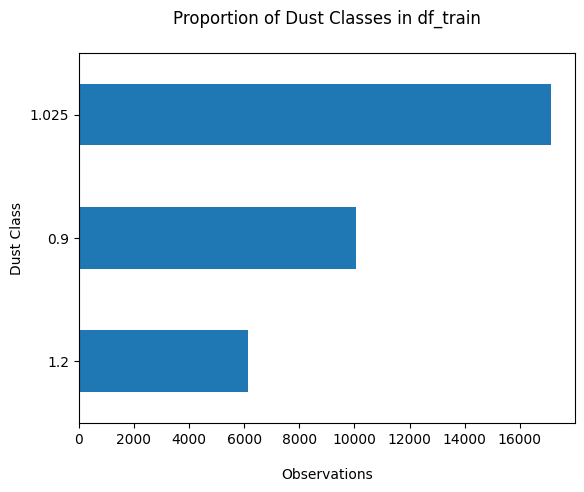

In [21]:
%matplotlib inline

category_totals = df_train.groupby('Dust')['Differential_pressure'].count().sort_values()
category_totals.plot(kind="barh", title='Proportion of Dust Classes in df_train\n', xlabel='\nObservations', ylabel='Dust Class')
category_totals

#### Our next aim is to 
* Fill these bins with data that best represents a central tendency.
* Make the size of each bin around ±**6100** observations (similar to the A4 Coarse Dust class bin) 

#### Procedure
* Include a comparison to how far each `differential_pressure` measure **deviates** or how far it is from the **.median()** value of the bin.
* Ordered by `filter_balance` showing sets with data closest to 600 Pa `differential_pressure`.
* Include comparison to median
* Add a cumulative measure of Data_No's to use as a ranking
* Create a dataframe of the A3 Medium Dust : **1.025**

Add a calculation of Standard Deviation to **df_train** test set and hide several colums for easier viewing

In [22]:
# del df_train['winz_Mean']
# del df_train['log_DP']
std_group = df_train.groupby('Data_No').std()
std_group.index.name = None
std_group.loc[:,'Data_No'] = std_group.index
map_std = df_train['Data_No'].map(std_group.set_index('Data_No')['Differential_pressure'])
df_train.loc[:,'std_DP'] = map_std
# df_test.loc[363:368]
df_train.loc[30082:30087].style.hide(['Time', 'Dust_feed', 'Flow_rate', 'Dust', 'mass_g', 'cumulative_mass_g', 'Tt'], axis="columns")

,Data_No,Differential_pressure,4point_EWM,log_EWM,change_DP,change_EWM,filter_balance,std_DP
30082,44,599.139200,598.591226,6.394579,-0.090400,0.365316,0.140000,165.794099
30083,44,599.772200,599.063616,6.395368,0.633000,0.472390,0.040000,165.794099
30084,44,600.947600,599.817209,6.396625,1.175400,0.753594,-0.160000,165.794099
30085,45,2.441406,1.427954,0.356242,1.265914,0.675635,99.590000,87.224704
30086,45,1.085069,1.290800,0.255262,-1.356337,-0.137154,99.820000,87.224704
30087,45,2.350984,1.714874,0.539339,1.265915,0.424074,99.610000,87.224704


Add a calculation of Coefficient of Variation (variance) to **df_train** test set

In [23]:
import numpy as np
cv = lambda data: np.std(data, ddof=1) / np.mean(data, axis=0) * 100 
var_group = df_train.groupby('Data_No').apply(cv)
var_group.index.name = None
var_group.loc[:,'Data_No'] = var_group.index
map_var = df_train['Data_No'].map(var_group.set_index('Data_No')['Differential_pressure'])
df_train.loc[:,'cv_DP'] = map_var
# df_test.loc[363:368]
df_train.loc[444:453]

/tmp/ipykernel_926/1494888632.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  var_group.loc[:,'Data_No'] = var_group.index


,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance,std_DP,cv_DP
444,2,3.707321,3.844114,1.346543,56.030844,5.3,236.428943,1.025,0.000000,-0.091196,0.24234,12.844002,44.9,99.38,49.479388,106.706319
445,2,3.707321,3.789397,1.332207,56.289163,5.4,236.428943,1.025,0.000000,-0.054717,0.24234,13.086342,44.9,99.38,49.479388,106.706319
446,2,7.505064,5.275664,1.663105,56.358716,5.5,236.428943,1.025,3.797743,1.486267,0.24234,13.328682,44.9,98.75,49.479388,106.706319
447,2,6.239150,5.661058,1.733611,56.746187,5.6,236.428943,1.025,-1.265914,0.385394,0.24234,13.571021,44.9,98.96,49.479388,106.706319
448,2,5.425347,5.566774,1.716816,56.328909,5.7,236.428943,1.025,-0.813803,-0.094285,0.24234,13.813361,44.9,99.10,49.479388,106.706319
449,2,3.616898,4.786823,1.565867,56.309043,5.8,236.428943,1.025,-1.808449,-0.779950,0.24234,14.055701,44.9,99.40,49.479388,106.706319
450,2,4.340278,4.608205,1.527838,56.348776,5.9,236.428943,1.025,0.723380,-0.178618,0.24234,14.298040,44.9,99.28,49.479388,106.706319
451,2,2.441406,3.741486,1.319483,56.626975,6.0,236.428943,1.025,-1.898872,-0.866720,0.24234,14.540380,44.9,99.59,49.479388,106.706319
452,2,2.441406,3.221454,1.169833,56.299103,6.1,236.428943,1.025,0.000000,-0.520032,0.24234,14.782720,44.9,99.59,49.479388,106.706319
453,2,3.707321,3.415801,1.228412,56.527615,6.2,236.428943,1.025,1.265915,0.194347,0.24234,15.025059,44.9,99.38,49.479388,106.706319


The coefficient of variation is an indication of how far the standard deviation is away from the mean. As we can see it does not add value to our understanding of the data, primarily due the the skewed nature of the `differential_pressure` continuous variable. 
* This re-enforces the understanding that descriptive statistics using the mean may not be preferred measure of central tendency.

**Remove Coefficient of Variation and Add Median to df_train**
* Median is the preferred measure of central tendency to observe in a skewed dataset such as this as it is not as affected by larger values.

In [24]:
del df_train['cv_DP']
median_group = df_train.groupby('Data_No').median()
median_group.index.name = None
median_group.loc[:,'Data_No'] = median_group.index
map_median = df_train['Data_No'].map(median_group.set_index('Data_No')['Differential_pressure'])
df_train.loc[:,'median_DP'] = map_median
# df_train.loc[444:453]
df_train.loc[444:453].head().style.hide(['Time', 'Dust_feed', 'Flow_rate', 'Dust', 'mass_g', 'cumulative_mass_g', 'Tt'], axis="columns")

,Data_No,Differential_pressure,4point_EWM,log_EWM,change_DP,change_EWM,filter_balance,std_DP,median_DP
444,2,3.707321,3.844114,1.346543,0.000000,-0.091196,99.380000,49.479388,24.594910
445,2,3.707321,3.789397,1.332207,0.000000,-0.054717,99.380000,49.479388,24.594910
446,2,7.505064,5.275664,1.663105,3.797743,1.486267,98.750000,49.479388,24.594910
447,2,6.239150,5.661058,1.733611,-1.265914,0.385394,98.960000,49.479388,24.594910
448,2,5.425347,5.566774,1.716816,-0.813803,-0.094285,99.100000,49.479388,24.594910


#### Now we can evaluate the dataframe with just **A3 Dust** in it, ordered by `filter_balance` as a measure of time to filter failure

Map the size of each bin and include a cumulative sum of each **bin size** to help see which data bin that reaches **6100** or more total values.

In [25]:
bin_sum = df_train.groupby('Data_No')['Data_No'].count().reset_index(name='bin_tot')
map_bin = df_train['Data_No'].map(bin_sum.set_index('Data_No')['bin_tot'])
df_train.loc[:, 'bin_size'] = map_bin

dust_A3 = df_train[df_train['Dust'] == 1.025]
filter_A3 = dust_A3[dust_A3.Data_No != dust_A3.Data_No.shift(-1)]
df_train_A3 = filter_A3.sort_values(by='filter_balance', ascending=True)

df_train_A3['c_sum'] = df_train_A3['bin_size'].cumsum()
dn_fb = df_train_A3.loc[:, 'Data_No'].head(14).sort_values(ascending=True).reset_index(drop=True)
df_train_A3.head(14).style.hide(['Time', 'Dust_feed', 'Flow_rate', 'Dust', 'mass_g', 'cumulative_mass_g', 'Tt'], axis="columns")

,Data_No,Differential_pressure,4point_EWM,log_EWM,change_DP,change_EWM,filter_balance,std_DP,median_DP,bin_size,c_sum
11421,14,477.340100,475.998323,6.165414,-1.265900,0.894518,20.440000,139.413195,99.103010,660,660
20105,28,471.101000,468.419097,6.149363,3.164800,1.787935,21.480000,141.291508,119.357600,586,1246
13952,18,393.518500,392.617426,5.972836,1.356300,0.600716,34.410000,112.921737,68.992330,657,1903
3047,5,358.072900,362.263856,5.892373,-9.132700,-2.793971,40.320000,106.286540,79.752610,886,2789
3931,6,355.902800,353.943527,5.869137,1.898900,1.306182,40.680000,102.669610,77.853740,884,3673
1276,3,350.929500,346.435321,5.847696,5.696600,2.996119,41.510000,107.313710,64.652050,436,4109
10761,13,344.871200,343.204157,5.838325,-0.542600,1.111362,42.520000,93.048032,43.945310,659,4768
10102,12,327.781400,326.849752,5.789501,0.000000,0.621099,45.370000,88.801121,48.556860,659,5427
5712,7,314.941400,313.287743,5.747122,1.265900,1.102438,47.510000,88.122758,64.923320,1781,7208
12083,15,292.787900,294.544928,5.685432,-3.164800,-1.171352,51.200000,81.099382,41.956020,662,7870


We can see that in the current dataframe containing only A3 Medium Dust observations, that is ordered by those tests with closest to a completed test to failure:
* **The top 9 data bins (seen at bin 7) would extract a A3 Medium dust training dataset with 7,208 observations**
* We will now perform a PDA to evaluate the suitability of these further

#### Rank by Standard Deviations, ordered by `std_DP`
The standard deviation is used to measure the spread of values in a sample.

In [26]:
# dust_A3 = df_train[df_train['Dust'] == 1.025]
# filter_A3 = dust_A3[dust_A3.Data_No != dust_A3.Data_No.shift(-1)]
df_train_A3_std = filter_A3.sort_values(by='std_DP', ascending=True)
df_train_A3_std['c_sum'] = df_train_A3_std['bin_size'].cumsum()
dn_sdv = df_train_A3_std.loc[:, 'Data_No'].head(14).sort_values(ascending=True).reset_index(drop=True)
df_train_A3_std.head(14).style.hide(['Time', 'Dust_feed', 'Flow_rate', 'Dust', 'mass_g', 'cumulative_mass_g', 'Tt'], axis="columns")

,Data_No,Differential_pressure,4point_EWM,log_EWM,change_DP,change_EWM,filter_balance,std_DP,median_DP,bin_size,c_sum
17221,22,69.534870,66.538647,4.197783,2.893520,1.997482,88.410000,17.666409,12.930410,417,417
20435,29,89.156550,88.236474,4.480020,1.175500,0.613384,85.140000,24.268682,22.831670,330,747
19519,27,110.044100,106.974874,4.672594,3.888100,2.046151,81.660000,26.317816,25.860820,365,1112
17916,23,114.655700,113.217094,4.729307,1.175500,0.959071,80.890000,29.559893,24.323640,695,1807
13295,17,145.218500,144.492476,4.973227,0.633000,0.484016,75.800000,37.653991,23.781110,552,2359
15647,20,155.074500,155.532987,5.046858,-1.265900,-0.305658,74.150000,41.197952,19.892940,1037,3396
18868,25,162.670000,158.902732,5.068292,3.074400,2.511512,72.890000,42.226819,23.509840,259,3655
14610,19,151.728900,151.273335,5.019088,-1.175500,0.303710,74.710000,44.065722,17.768015,658,4313
840,2,196.668800,194.114101,5.268446,0.452100,1.703133,67.220000,49.479388,24.594910,446,4759
19154,26,198.296400,198.442815,5.290501,-1.898900,-0.097610,66.950000,57.291608,37.977430,286,5045


#### Rank by central tenancy of the Median value, ordered by `median_DP`
* Median = the value of the number in the middle of the dataset

In [27]:
# dust_A3 = df_train[df_train['Dust'] == 1.025]
# filter_A3 = dust_A3[dust_A3.Data_No != dust_A3.Data_No.shift(-1)]
df_train_A3_median = filter_A3.sort_values(by='median_DP', ascending=False)
df_train_A3_median['c_sum'] = df_train_A3_median['bin_size'].cumsum()
dn_mdp = df_train_A3_median.loc[:, 'Data_No'].head(14).sort_values(ascending=True).reset_index(drop=True)
df_train_A3_median.head(14).style.hide(['Time', 'Dust_feed', 'Flow_rate', 'Dust', 'mass_g', 'cumulative_mass_g', 'Tt'], axis="columns")

,Data_No,Differential_pressure,4point_EWM,log_EWM,change_DP,change_EWM,filter_balance,std_DP,median_DP,bin_size,c_sum
20105,28,471.101000,468.419097,6.149363,3.164800,1.787935,21.480000,141.291508,119.357600,586,586
11421,14,477.340100,475.998323,6.165414,-1.265900,0.894518,20.440000,139.413195,99.103010,660,1246
3047,5,358.072900,362.263856,5.892373,-9.132700,-2.793971,40.320000,106.286540,79.752610,886,2132
3931,6,355.902800,353.943527,5.869137,1.898900,1.306182,40.680000,102.669610,77.853740,884,3016
13952,18,393.518500,392.617426,5.972836,1.356300,0.600716,34.410000,112.921737,68.992330,657,3673
5712,7,314.941400,313.287743,5.747122,1.265900,1.102438,47.510000,88.122758,64.923320,1781,5454
1276,3,350.929500,346.435321,5.847696,5.696600,2.996119,41.510000,107.313710,64.652050,436,5890
20866,30,248.119200,244.936591,5.500999,1.808400,2.121739,58.650000,70.535031,62.662760,431,6321
2161,4,228.226300,228.658503,5.432230,-1.808400,-0.288135,61.960000,63.148067,50.907840,885,7206
18609,24,226.598700,224.847198,5.415421,0.000000,1.167668,62.230000,66.045838,49.280240,693,7899


Review of the **data bin numbers** across descriptors of central tendency that would capture **6100** or more total values:

In [28]:
dn_review = pd.DataFrame()
dn_review.insert(loc=0, column='by_std_DP', value=dn_sdv)
dn_review.insert(loc=0, column='by_median_DP', value=dn_mdp)
dn_review.insert(loc=0, column='by_filter_balance', value=dn_fb)
dn_review

,by_filter_balance,by_median_DP,by_std_DP
0,1,3,1
1,3,4,2
2,4,5,4
3,5,6,16
4,6,7,17
5,7,12,19
6,12,13,20
7,13,14,22
8,14,15,23
9,15,16,24


#### Considerations

* We can see that when we filter by **filter balance** or **median differential pressure** that most bin numbers are contained in both. In fact only bins 1, 16, and 24 are not contained in both, se we can consider these as the first to re-introduce to the data, perhaps when creating the validation set. 
    * This provides us with confidence that these test are higher value for our purposes and promote inclusion into our A3 Dust group.
* Reviewing those values with the lowest **Standard Deviation** inadvertently includes selects values furthest from fully completing a test (ie differential pressure reaching > 600 Pa). In such, these bins will not factor highly in our considerations to include in the dataset. 

---

## Feature Selection

* A **Selected Feature**: *The process of selecting a subset of relevant features (variables, predictors) for use in model construction*. 

Feature selection techniques are used for several reasons:

* Simplification of models to make them easier to interpret by researchers/users
* Shorter training times
* Avoiding too many input variables (dimensionality)
* Improve the data's compatibility with a learning model class
* Create symmetries in the input data.

The main idea when using a feature selection is that the data contains some features that are either **surplus**, **redundant** or **irrelevant** to the final business goal and can therefore be removed without incurring much loss of predictive power.

### Extracting bins from the **Training** dataset

Make a separate frame indicating the bin numbers we wish to extract

In [29]:
bin_no = df_train_A3['Data_No'].head(9)
bin_no.to_frame()

,Data_No
11421,14
20105,28
13952,18
3047,5
3931,6
1276,3
10761,13
10102,12
5712,7


Use these references to create a dataframe `df_train_cleaned_A3` that is ready for inclusion in our final dataframe `df_train_clean`.
* Note we disregard the cumulative sum measure as it doesn't add value to further calculations

In [30]:
df_train_copy = df_train
df_train_cleaned_A3 = df_train_copy[df_train_copy['Data_No'].isin(bin_no)]
df_train_cleaned_A3

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance,std_DP,median_DP,bin_size
841,3,2.260561,1.208044,0.189002,55.742718,1.4,236.428943,1.025,1.265914,0.701678,0.242340,3.392755,44.9,99.62,107.313710,64.65205,436
842,3,3.526476,2.135417,0.758662,55.335380,1.5,236.428943,1.025,1.265915,0.927373,0.242340,3.635095,44.9,99.41,107.313710,64.65205,436
843,3,3.526476,2.691840,0.990225,55.772525,1.6,236.428943,1.025,0.000000,0.556424,0.242340,3.877435,44.9,99.41,107.313710,64.65205,436
844,3,5.425347,3.785243,1.331110,55.871884,1.7,236.428943,1.025,1.898871,1.093403,0.242340,4.119774,44.9,99.10,107.313710,64.65205,436
845,3,4.249856,3.971088,1.379040,56.199743,1.8,236.428943,1.025,-1.175491,0.185845,0.242340,4.362114,44.9,99.29,107.313710,64.65205,436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,28,467.936200,465.270181,6.142618,82.709333,59.4,177.321707,1.025,1.898900,1.777346,0.181755,107.962322,157.2,22.01,141.291508,119.35760,586
20102,28,466.037300,465.577028,6.143278,82.269684,59.5,177.321707,1.025,-1.898900,0.306848,0.181755,108.144076,157.2,22.33,141.291508,119.35760,586
20103,28,466.037300,465.761137,6.143673,82.024495,59.6,177.321707,1.025,0.000000,0.184109,0.181755,108.325831,157.2,22.33,141.291508,119.35760,586
20104,28,467.936200,466.631162,6.145539,82.743156,59.7,177.321707,1.025,1.898900,0.870025,0.181755,108.507586,157.2,22.01,141.291508,119.35760,586


#### A Quick Review: 

In [31]:
print('Shape started with: ', dust_A3.shape)
print('Shape we have now: ', df_train_cleaned_A3.shape)

Shape started with:  (17136, 17)
Shape we have now:  (7208, 17)


Add these to a new dataset to compare

In [32]:
dust_A2 = df_train[df_train['Dust'] == 0.900]
dust_A3 = df_train_cleaned_A3
dust_A4 = df_train[df_train['Dust'] == 1.200]

df_train_compare = pd.concat([dust_A2, dust_A3, dust_A4], ignore_index = True)
df_train_compare

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance,std_DP,median_DP,bin_size
0,8,4.159433,1.663773,0.509088,79.771690,0.6,59.107236,0.9,4.159433,1.663773,0.053197,0.319179,179.4,99.31,171.755617,120.6236,1789
1,8,6.691262,3.674769,1.301490,80.820436,0.7,59.107236,0.9,2.531829,2.010996,0.053197,0.372376,179.4,98.88,171.755617,120.6236,1789
2,8,9.856047,6.147280,1.816010,80.605533,0.8,59.107236,0.9,3.164785,2.472511,0.053197,0.425572,179.4,98.36,171.755617,120.6236,1789
3,8,12.749570,8.788196,2.173409,80.639911,0.9,59.107236,0.9,2.893523,2.640916,0.053197,0.478769,179.4,97.88,171.755617,120.6236,1789
4,8,14.738860,11.168462,2.413094,80.786058,1.0,59.107236,0.9,1.989290,2.380266,0.053197,0.531965,179.4,97.54,171.755617,120.6236,1789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23391,50,359.971800,357.193974,5.878279,58.721877,59.4,177.321707,1.2,1.627600,1.851884,0.212786,126.394913,59.8,40.00,103.693631,74.5081,427
23392,50,360.785600,358.630624,5.882293,58.699919,59.5,177.321707,1.2,0.813800,1.436651,0.212786,126.607699,59.8,39.87,103.693631,74.5081,427
23393,50,361.509000,359.781974,5.885498,58.743820,59.6,177.321707,1.2,0.723400,1.151350,0.212786,126.820485,59.8,39.75,103.693631,74.5081,427
23394,50,362.051500,360.689785,5.888018,58.601152,59.7,177.321707,1.2,0.542500,0.907810,0.212786,127.033271,59.8,39.66,103.693631,74.5081,427


Dust
1.200     6142
1.025     7208
0.900    10046
Name: Differential_pressure, dtype: int64

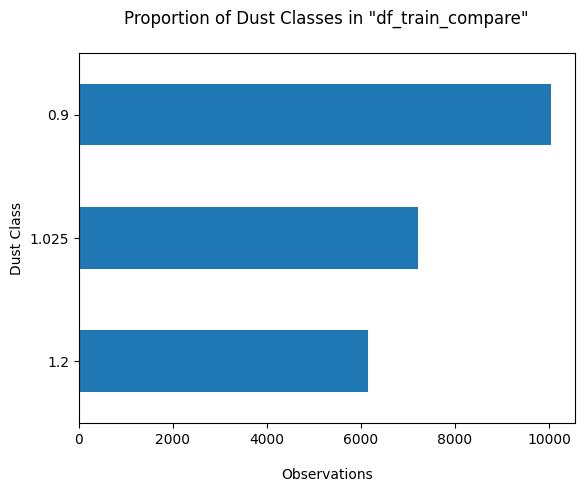

In [33]:
%matplotlib inline

category_totals = df_train_compare.groupby('Dust')['Differential_pressure'].count().sort_values()
category_totals.plot(kind="barh", title='Proportion of Dust Classes in "df_train_compare"\n', xlabel='\nObservations', ylabel='Dust Class')
category_totals

### Repeat procedure with remaining `Dust` classes and **Test** dataset

Extract, Clear and Replace...

In [34]:
# bin_sum = df_train.groupby('Data_No')['Data_No'].count().reset_index(name='bin_Tot')
# map_bin = df_train['Data_No'].map(bin_sum.set_index('Data_No')['bin_Tot'])
# df_train.loc[:, 'bin_Size'] = map_bin

# df_train.loc[38817:38827]

dust_A2 = df_train[df_train['Dust'] == 0.900]
filter_A2 = dust_A2[dust_A2.Data_No != dust_A2.Data_No.shift(-1)]
df_train_A2 = filter_A2.sort_values(by='filter_balance', ascending=True)
df_train_A2['c_sum'] = df_train_A2['bin_size'].cumsum()
df_train_A2.head(13).style.hide(['Time', 'Dust_feed', 'Flow_rate', 'Dust', 'mass_g', 'cumulative_mass_g', 'Tt'], axis="columns")

,Data_No,Differential_pressure,4point_EWM,log_EWM,change_DP,change_EWM,filter_balance,std_DP,median_DP,bin_size,c_sum
31415,46,607.910200,595.680737,6.389705,11.845400,8.152975,-1.320000,182.914050,134.006100,608,608
9443,11,604.926200,594.434824,6.387611,8.138000,6.994251,-0.820000,176.695893,140.878200,623,1231
29440,43,601.038000,598.488796,6.394408,4.340200,1.699469,-0.170000,172.359137,103.533700,1007,2238
30084,44,600.947600,599.817209,6.396625,1.175400,0.753594,-0.160000,165.794099,85.946545,644,2882
32283,47,600.224200,597.957161,6.393519,0.542500,1.511359,-0.040000,177.766979,107.150600,868,3750
7501,8,589.192700,587.561629,6.375981,1.265900,1.087381,1.800000,171.755617,120.623600,1789,5539
8820,10,364.040800,381.276529,5.943525,-29.477700,-11.490486,39.330000,111.238925,77.220770,659,6198
8161,9,330.765300,325.634930,5.785777,3.526400,3.420247,44.870000,81.224564,50.546155,660,6858
30807,45,312.409600,311.549846,5.741559,-0.090400,0.573169,47.930000,87.224704,59.497970,723,7581
28433,42,240.704600,240.043114,5.480819,1.808500,0.440991,59.880000,71.569630,51.450370,1013,8594


In [35]:
bin_no = df_train_A2['Data_No'].head(9)
bin_no.to_frame()

,Data_No
31415,46
9443,11
29440,43
30084,44
32283,47
7501,8
8820,10
8161,9
30807,45


In [36]:
df_train_copy = df_train
df_train_cleaned_A2 = df_train_copy[df_train_copy['Data_No'].isin(bin_no)]
df_train_cleaned_A2

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance,std_DP,median_DP,bin_size
5713,8,4.159433,1.663773,0.509088,79.771690,0.6,59.107236,0.9,4.159433,1.663773,0.053197,0.319179,179.4,99.31,171.755617,120.6236,1789
5714,8,6.691262,3.674769,1.301490,80.820436,0.7,59.107236,0.9,2.531829,2.010996,0.053197,0.372376,179.4,98.88,171.755617,120.6236,1789
5715,8,9.856047,6.147280,1.816010,80.605533,0.8,59.107236,0.9,3.164785,2.472511,0.053197,0.425572,179.4,98.36,171.755617,120.6236,1789
5716,8,12.749570,8.788196,2.173409,80.639911,0.9,59.107236,0.9,2.893523,2.640916,0.053197,0.478769,179.4,97.88,171.755617,120.6236,1789
5717,8,14.738860,11.168462,2.413094,80.786058,1.0,59.107236,0.9,1.989290,2.380266,0.053197,0.531965,179.4,97.54,171.755617,120.6236,1789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32279,47,594.527600,588.377825,6.377369,59.103897,104.2,79.246266,0.9,4.340200,4.099850,0.071322,74.317149,104.6,0.91,177.766979,107.1506,868
32280,47,596.426500,591.597295,6.382826,59.377463,104.3,79.246266,0.9,1.898900,3.219470,0.071322,74.388470,104.6,0.60,177.766979,107.1506,868
32281,47,598.325400,594.288537,6.387365,59.281707,104.4,79.246266,0.9,1.898900,2.691242,0.071322,74.459792,104.6,0.28,177.766979,107.1506,868
32282,47,599.681700,596.445802,6.390988,58.996220,104.5,79.246266,0.9,1.356300,2.157265,0.071322,74.531113,104.6,0.05,177.766979,107.1506,868


In [37]:
dust_A2 = df_train_cleaned_A2
dust_A3 = df_train_cleaned_A3
dust_A4 = df_train[df_train['Dust'] == 1.200]

df_train_compare = pd.concat([dust_A2, dust_A3, dust_A4], ignore_index = True)
df_train_compare

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance,std_DP,median_DP,bin_size
0,8,4.159433,1.663773,0.509088,79.771690,0.6,59.107236,0.9,4.159433,1.663773,0.053197,0.319179,179.4,99.31,171.755617,120.6236,1789
1,8,6.691262,3.674769,1.301490,80.820436,0.7,59.107236,0.9,2.531829,2.010996,0.053197,0.372376,179.4,98.88,171.755617,120.6236,1789
2,8,9.856047,6.147280,1.816010,80.605533,0.8,59.107236,0.9,3.164785,2.472511,0.053197,0.425572,179.4,98.36,171.755617,120.6236,1789
3,8,12.749570,8.788196,2.173409,80.639911,0.9,59.107236,0.9,2.893523,2.640916,0.053197,0.478769,179.4,97.88,171.755617,120.6236,1789
4,8,14.738860,11.168462,2.413094,80.786058,1.0,59.107236,0.9,1.989290,2.380266,0.053197,0.531965,179.4,97.54,171.755617,120.6236,1789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20926,50,359.971800,357.193974,5.878279,58.721877,59.4,177.321707,1.2,1.627600,1.851884,0.212786,126.394913,59.8,40.00,103.693631,74.5081,427
20927,50,360.785600,358.630624,5.882293,58.699919,59.5,177.321707,1.2,0.813800,1.436651,0.212786,126.607699,59.8,39.87,103.693631,74.5081,427
20928,50,361.509000,359.781974,5.885498,58.743820,59.6,177.321707,1.2,0.723400,1.151350,0.212786,126.820485,59.8,39.75,103.693631,74.5081,427
20929,50,362.051500,360.689785,5.888018,58.601152,59.7,177.321707,1.2,0.542500,0.907810,0.212786,127.033271,59.8,39.66,103.693631,74.5081,427


Dust
1.200    6142
1.025    7208
0.900    7581
Name: Differential_pressure, dtype: int64

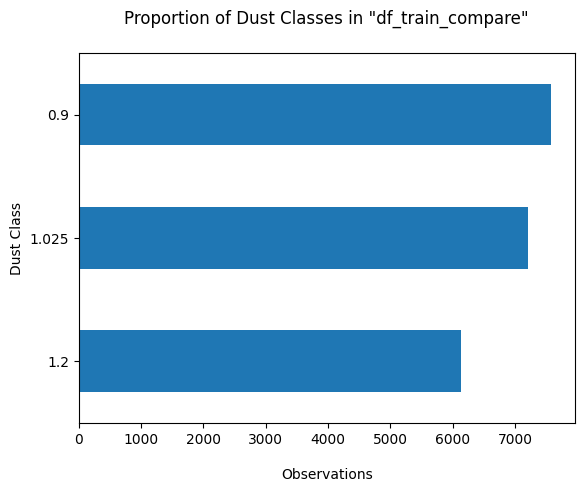

In [38]:
%matplotlib inline

category_totals = df_train_compare.groupby('Dust')['Differential_pressure'].count().sort_values()
category_totals.plot(kind="barh", title='Proportion of Dust Classes in "df_train_compare"\n', xlabel='\nObservations', ylabel='Dust Class')
category_totals

### **How much data do we need**?
* At a bin sample of 9 for both A2 and A3 dust, we currently have a little under 15,000 observations to train the ML Models
* Will review this depending on the performance of the models
* Overfitting with too much data vs underfitting with too little is a balance and the qualitative nature of the heuristics surrounding the predictions made
* Nonlinear Algorithms (like clustering) may need more data

Short answer is, **we have plenty of extra data at this point that may be less suited to training the model**. 

* Notwithstanding, it is still live data and may there may be some value toward increasing the power of our ML Models. 
* We also have the option to alter the selected number of dust class bins and possibly augmenting the smaller A4 dust dataset with the **Synthetic Minority Oversampling Technique (SMOTE)** or SMOTE NC for categorical data should we need.

In [39]:
# df_train_cleaned = df_train_compare
# df_train_cleaned
df_train_transformed = df_train_compare
df_train_transformed

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance,std_DP,median_DP,bin_size
0,8,4.159433,1.663773,0.509088,79.771690,0.6,59.107236,0.9,4.159433,1.663773,0.053197,0.319179,179.4,99.31,171.755617,120.6236,1789
1,8,6.691262,3.674769,1.301490,80.820436,0.7,59.107236,0.9,2.531829,2.010996,0.053197,0.372376,179.4,98.88,171.755617,120.6236,1789
2,8,9.856047,6.147280,1.816010,80.605533,0.8,59.107236,0.9,3.164785,2.472511,0.053197,0.425572,179.4,98.36,171.755617,120.6236,1789
3,8,12.749570,8.788196,2.173409,80.639911,0.9,59.107236,0.9,2.893523,2.640916,0.053197,0.478769,179.4,97.88,171.755617,120.6236,1789
4,8,14.738860,11.168462,2.413094,80.786058,1.0,59.107236,0.9,1.989290,2.380266,0.053197,0.531965,179.4,97.54,171.755617,120.6236,1789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20926,50,359.971800,357.193974,5.878279,58.721877,59.4,177.321707,1.2,1.627600,1.851884,0.212786,126.394913,59.8,40.00,103.693631,74.5081,427
20927,50,360.785600,358.630624,5.882293,58.699919,59.5,177.321707,1.2,0.813800,1.436651,0.212786,126.607699,59.8,39.87,103.693631,74.5081,427
20928,50,361.509000,359.781974,5.885498,58.743820,59.6,177.321707,1.2,0.723400,1.151350,0.212786,126.820485,59.8,39.75,103.693631,74.5081,427
20929,50,362.051500,360.689785,5.888018,58.601152,59.7,177.321707,1.2,0.542500,0.907810,0.212786,127.033271,59.8,39.66,103.693631,74.5081,427


We could run the **test data** through the above process, however it is intended to *test* the models and make sure they’ll work when new data is introduced. We do not want to taylor this data too much as it may promote overfitting the model.

## Other Feature Selection Considerations

Popular filter metrics for **classification problems** are 
* **Correlation-based feature selection**
* Mutual information
* Class separability
    * Error probability
    * Inter-class distance
    * Probabilistic distance
    * Entropy
* **Consistency-based feature selection**
* **Correlation-based feature selection**

#### Correlation Based Feature Selection


In [40]:
df_train_transformed.head()

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance,std_DP,median_DP,bin_size
0,8,4.159433,1.663773,0.509088,79.771690,0.6,59.107236,0.9,4.159433,1.663773,0.053197,0.319179,179.4,99.31,171.755617,120.6236,1789
1,8,6.691262,3.674769,1.301490,80.820436,0.7,59.107236,0.9,2.531829,2.010996,0.053197,0.372376,179.4,98.88,171.755617,120.6236,1789
2,8,9.856047,6.147280,1.816010,80.605533,0.8,59.107236,0.9,3.164785,2.472511,0.053197,0.425572,179.4,98.36,171.755617,120.6236,1789
3,8,12.749570,8.788196,2.173409,80.639911,0.9,59.107236,0.9,2.893523,2.640916,0.053197,0.478769,179.4,97.88,171.755617,120.6236,1789
4,8,14.738860,11.168462,2.413094,80.786058,1.0,59.107236,0.9,1.989290,2.380266,0.053197,0.531965,179.4,97.54,171.755617,120.6236,1789


Plot relevant relationships to **train** dataset

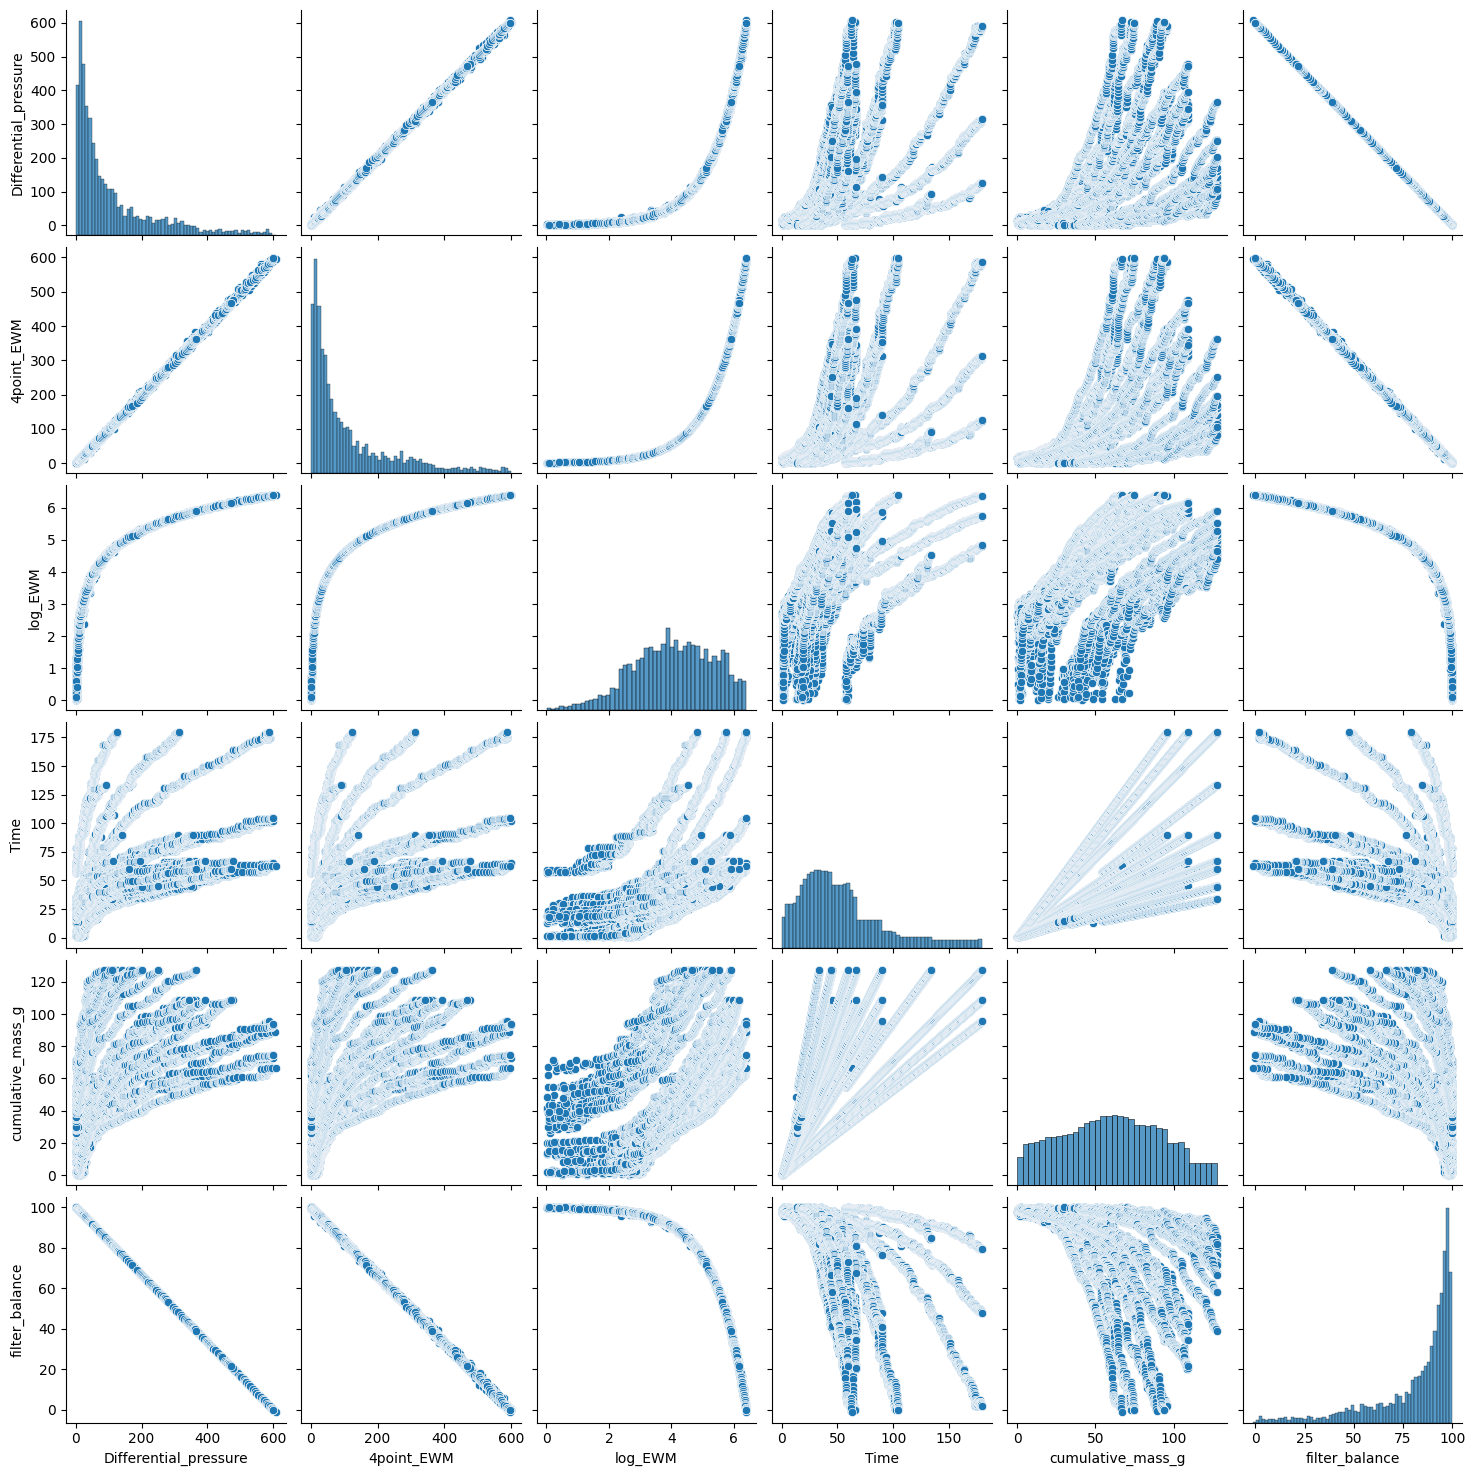

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

df_train_corr = df_train_transformed.drop(['Data_No', 'Flow_rate', 'Dust', 'mass_g', 'Dust_feed', 'Tt', 'bin_size', 'median_DP', 'std_DP', 'change_DP', 'change_EWM'], axis="columns")
sns.pairplot(data=df_train_corr)

Plot relevant relationships to **test** dataset (includes RUL)

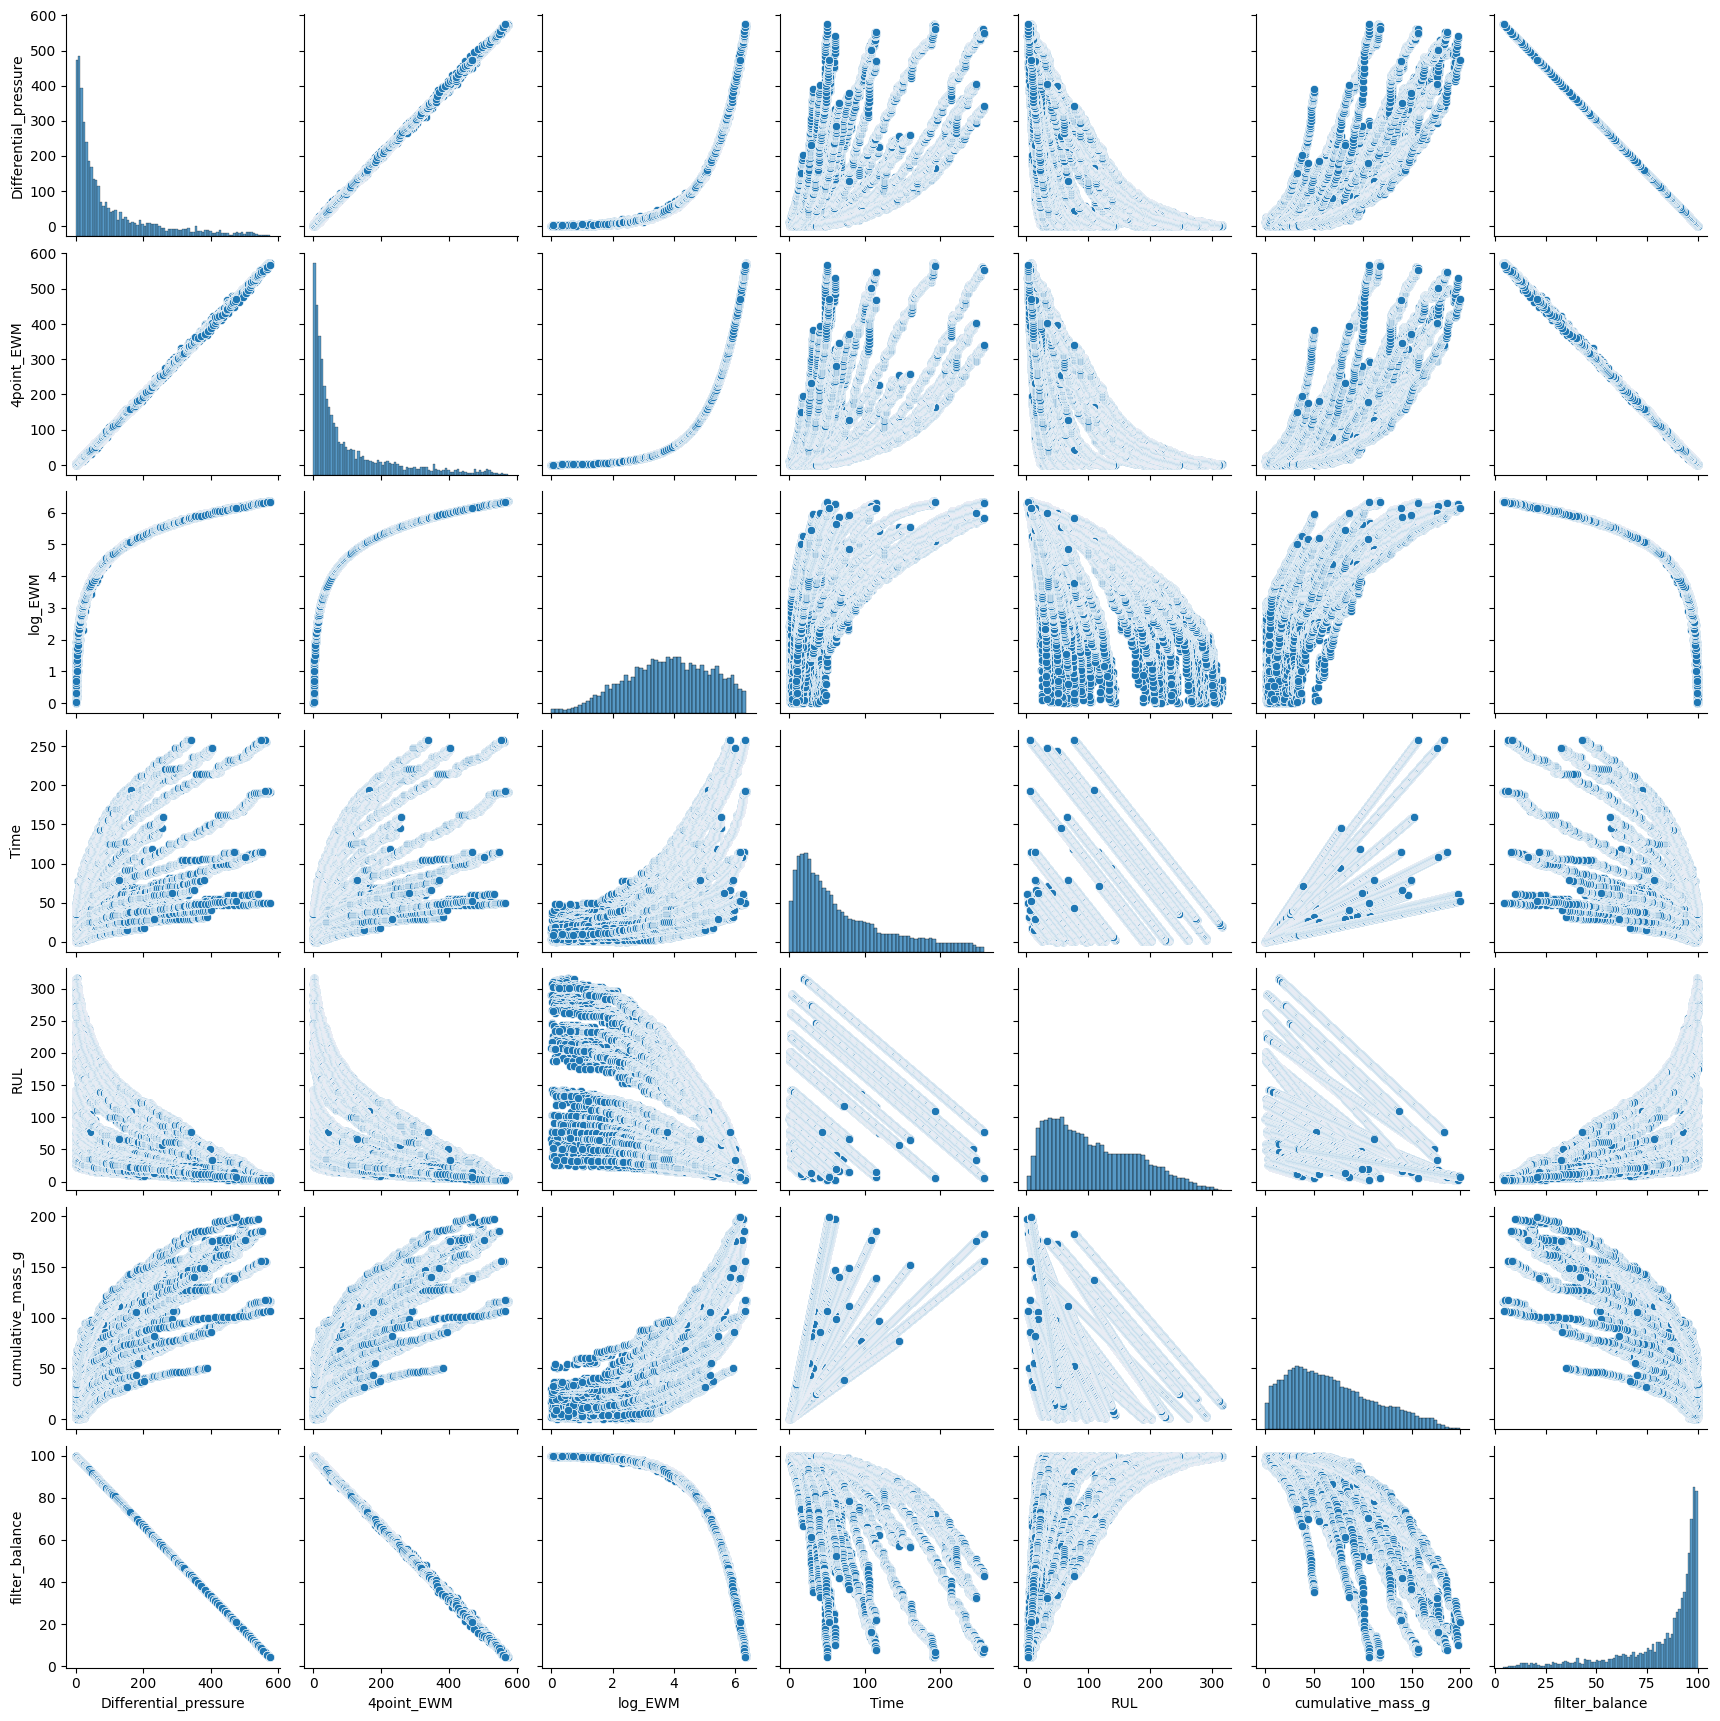

In [42]:
df_test_corr = df_test.drop(['Data_No', 'Flow_rate', 'Dust', 'mass_g', 'Dust_feed', 'Tt', 'change_DP', 'change_EWM'], axis="columns")
sns.pairplot(data=df_test_corr)

With a quick look, we notice the same relationships between `differential_pressure`, `RUL` and `Time`, with our engineered variables also indicating influence.

#### Heatmaps for **df_train** engineered dataset

Import ppscore function (Code Institute [Exploratory Data Analysis Tools](https://learn.codeinstitute.net/courses/course-v1:CodeInstitute+DDA101+2021_T4/courseware/468437859a944f7d81a34234957d825b/c8ea2343476c48739676b7f03ba9b08e/) 2022).

In [43]:
import numpy as np
import ppscore as pps

def heatmap_corr(df, threshold, figsize=(10, 8), font_annot=8):
    """
    Heatmap for pearson (linear) and spearman (monotonic) correlations to 
    visualize only those correlation levels greater than a given threshold.
    """
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={'size': font_annot}, ax=axes,
                    linewidth=0.01, linecolor='WhiteSmoke'
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(10, 8), font_annot=8):
    """
    Heatmap for power predictive score
    PPS == 0 means that there is no predictive power
    PPS < 0.2 often means that there is some relevant predictive power but it is weak
    PPS > 0.2 often means that there is strong predictive power
    PPS > 0.8 often means that there is a deterministic relationship in the data,
    """
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={'size': font_annot},
                         linewidth=0.01, linecolor='WhiteSmoke')
        plt.ylim(len(df.columns), 0)
        plt.show()


def calculate_corr_and_pps(df):
    """
    Calculate the correlations and ppscore of a given dataframe
    """
    df_corr_spearman = df.corr(method='spearman')
    df_corr_pearson = df.corr(method='pearson')

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query('ppscore < 1').filter(['ppscore']).describe().T
    print('PPS threshold - check PPS score IQR to decide threshold for heatmap \n')
    print(pps_score_stats.round(4))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def display_corr_and_pps(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(10, 8), font_annot=8):
    """
    Render the correlations and ppscore heatmaps for a given dataframe
    """
    # print('\n')
    print('To analyze: \n** Colinearity: how the target variable is correlated with the other features (variables)')
    print('** Multi-colinearity: how each feature correlates among themselves (multi-colinearity)')

    print('\n')
    print('*** Heatmap: Pearson Correlation ***')
    print(f'It evaluates the linear relationship between two continuous variables \n'
          f'* A +ve correlation indicates that as one variable increases the other variable tends to increase.\n'
          f'A correlation near zero indicates that as one variable increases, there is no tendency in the other variable to either increase or decrease.\n'
          f'A -ve correlation indicates that as one variable increases the other variable tends to decrease.')
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print('\n')
    print(f'*** Heatmap: Spearman Correlation ***')
    print(f'It evaluates monotonic relationship \n'
          f'Spearman correlation coefficients range from -1 to +1.\n'
          f'The sign of the coefficient indicates whether it is a positive or negative monotonic relationship.\n'
          f'* A positive correlation means that as one variable increases, the other variable also tends to increase.')
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print('\n')
    print('*** Heatmap: Power Predictive Score (PPS) ***')
    print(f'PPS detects linear or non-linear relationships between two columns.\n'
          f'The variable on the x-axis is used to predict the corresponding variable on the y-axis.\n'
          f'The score ranges from 0 (no predictive power) to 1 (perfect predictive power)\n\n'
          f'* PPS == 0 means that there is no predictive power\n'
          f'* PPS < 0.2 often means that there is some relevant predictive power but it is weak\n'
          f'* PPS > 0.2 often means that there is strong predictive power\n'
          f'* PPS > 0.8 often means that there is a deterministic relationship in the data\n')
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [44]:
df_drop = df_train_transformed.drop(['Data_No', 'Flow_rate', 'Dust', 'mass_g', 'Dust_feed', 'Tt', 'bin_size', 'median_DP', 'std_DP', 'change_DP', 'change_EWM'], axis="columns")
df_corr_pearson, df_corr_spearman, pps_matrix = calculate_corr_and_pps(df_drop)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count    mean     std  min    25%     50%    75%     max
ppscore   30.0  0.4509  0.4549  0.0  0.013  0.2722  0.982  0.9993


To analyze: 
** Colinearity: how the target variable is correlated with the other features (variables)
** Multi-colinearity: how each feature correlates among themselves (multi-colinearity)


*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 
* A +ve correlation indicates that as one variable increases the other variable tends to increase.
A correlation near zero indicates that as one variable increases, there is no tendency in the other variable to either increase or decrease.
A -ve correlation indicates that as one variable increases the other variable tends to decrease.


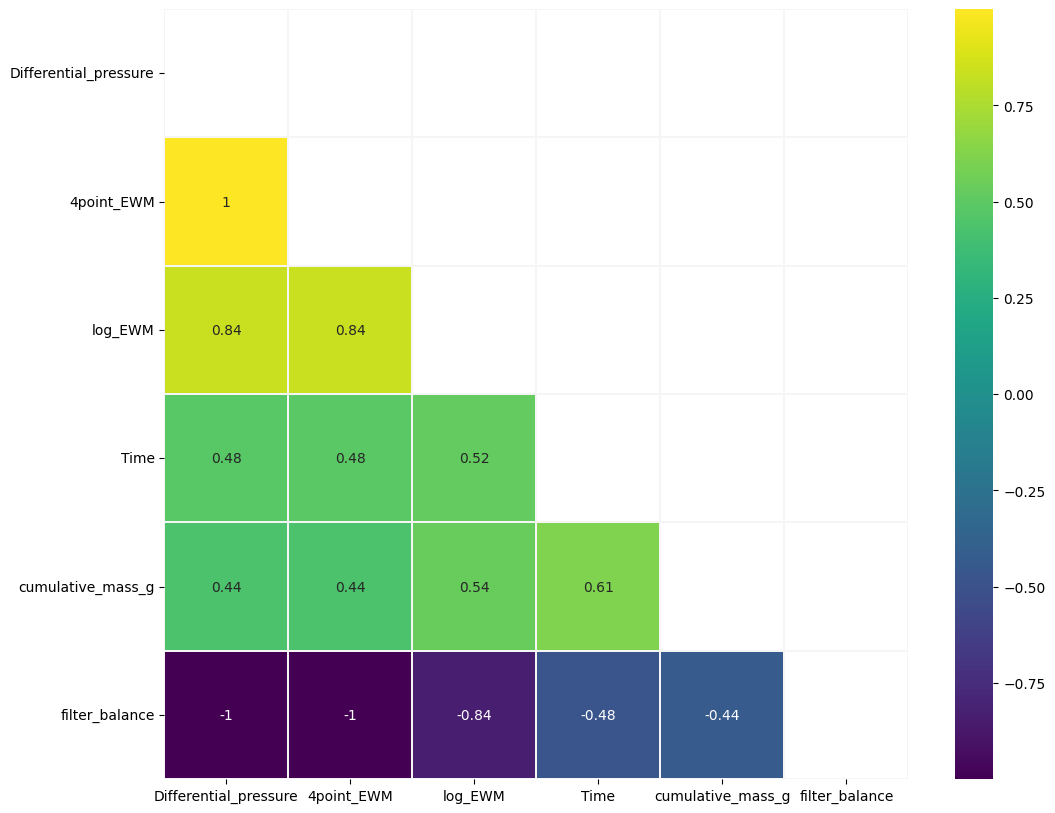



*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 
Spearman correlation coefficients range from -1 to +1.
The sign of the coefficient indicates whether it is a positive or negative monotonic relationship.
* A positive correlation means that as one variable increases, the other variable also tends to increase.


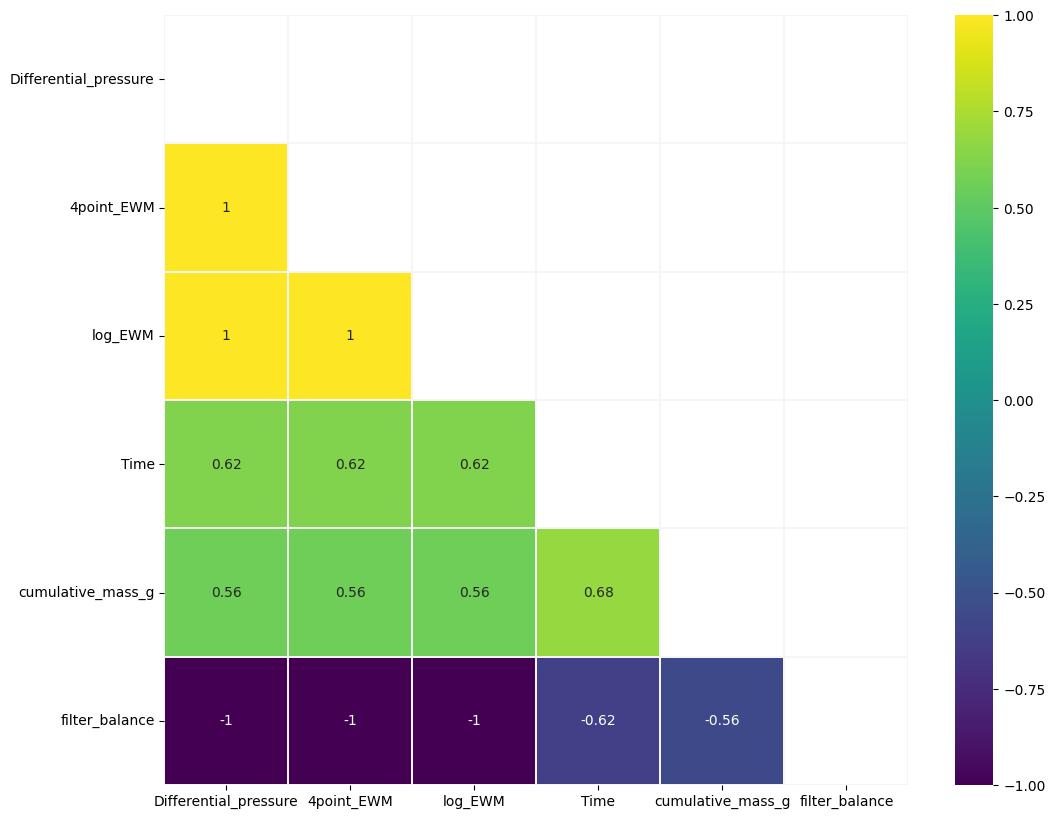



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The variable on the x-axis is used to predict the corresponding variable on the y-axis.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power)

* PPS == 0 means that there is no predictive power
* PPS < 0.2 often means that there is some relevant predictive power but it is weak
* PPS > 0.2 often means that there is strong predictive power
* PPS > 0.8 often means that there is a deterministic relationship in the data



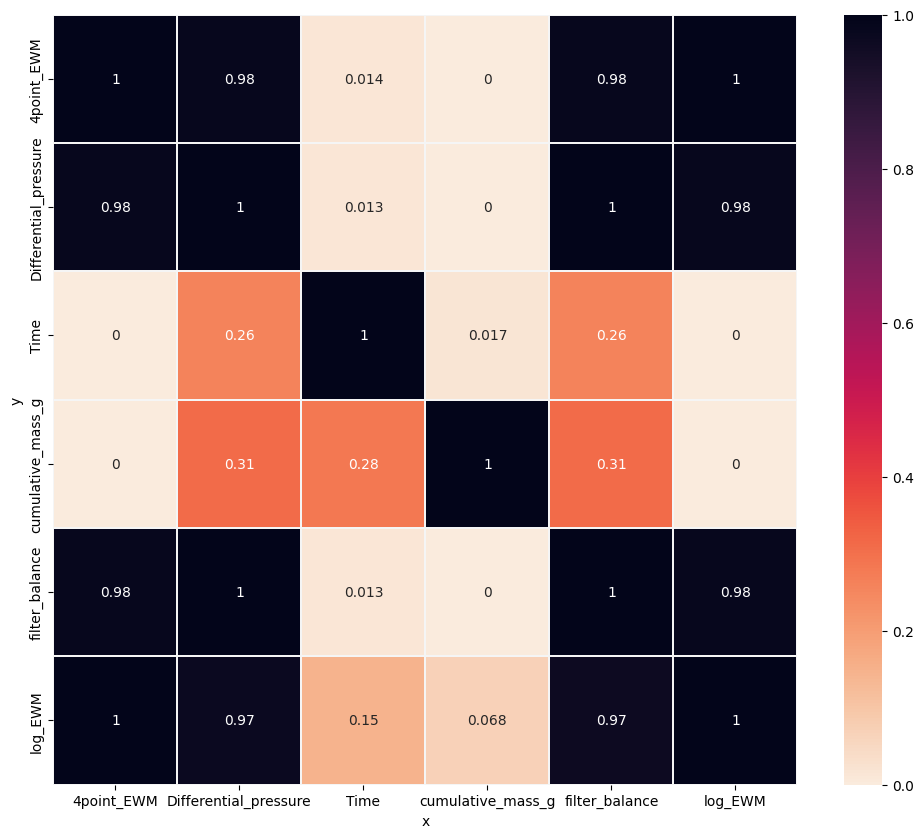

In [45]:
display_corr_and_pps(df_corr_pearson = df_corr_pearson, df_corr_spearman = df_corr_spearman,
                    pps_matrix = pps_matrix, CorrThreshold = 0, PPS_Threshold =0,
                    figsize=(12,10), font_annot=10
                    )

### Observations
Maintaining the observations we have previously made at 02_DataCleaning notebook, we also note:

* As we would think, there is a strong linear relationship between **Exponential Weighted Mean** (4pointEWM) and **Differential Pressure** (DP), indicating that we can confidently consider 4pointEWM (and its log value) as a proxy for DP.
    * Subsequently there is a strong **inverse** linear relationship between Exponential Weighted Mean (4pointEWM) and **Remaining Filter Balance**.
    
* Cumulative mass and time have a mildly positive relationship to Differential Pressure values, however their power to predict it is considered **none** to very weak at best.

## **SmartCorrelatedSelection** of Variables

[Feature Engine](https://pypi.org/project/feature-engine/) is a python library with multiple transformers to engineer and select features for use in machine learning models. 

`pip install feature-engine`

Applied here to confirm our conclusions, it looks for groups of features that correlate amongst themselves and removes any surplus correlated features since they add the same information to the model.

The transformer finds the groups and drops the features based on the **method**, **threshold** and **selection** method we choose.

For every group of correlated features, the transformer will remove all but one feature.

* Step 1: Create a separate DataFrame, with the variable(s)

In [46]:
df_engineering = df_total.copy().drop(['change_DP', 'change_EWM'], axis="columns")
df_engineering.head()

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,mass_g,cumulative_mass_g,Tt,filter_balance
54,1,1.537182,1.046296,0.045257,54.143527,5.5,236.428943,1.025,NaN,0.24234,13.328682,44.9,99.74
55,1,1.537182,1.242651,0.217247,54.518255,5.6,236.428943,1.025,NaN,0.24234,13.571021,44.9,99.74
56,1,1.537182,1.360463,0.307825,54.658781,5.7,236.428943,1.025,NaN,0.24234,13.813361,44.9,99.74
57,1,3.345631,2.154530,0.767573,54.780562,5.8,236.428943,1.025,NaN,0.24234,14.055701,44.9,99.44
58,1,5.244502,3.390519,1.220983,54.574466,5.9,236.428943,1.025,NaN,0.24234,14.298040,44.9,99.13


* Step 2: Create engineered variables(s) applying the transformation(s)

In [47]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
# corr_sel.correlated_feature_sets_
print('Correlated Variables :\n', corr_sel.correlated_feature_sets_)
print('\nFeatures to Drop :\n', corr_sel.features_to_drop_)

Correlated Variables :
 [{'cumulative_mass_g', 'log_EWM', 'Differential_pressure', 'filter_balance', '4point_EWM', 'Time'}, {'RUL', 'mass_g', 'Dust_feed', 'Tt'}]

Features to Drop :
 ['4point_EWM', 'log_EWM', 'Time', 'RUL', 'mass_g', 'cumulative_mass_g', 'Tt', 'filter_balance']


On running the transformer, it found 2 groups of correlated features:
1. `'DeviceProtection', 'OnlineBackup', 'OnlineSecurity', 'TechSupport',`
2. `'mass_g', 'Tt', 'Dust_feed', 'RUL'`

* It decided `Differential_pressure` was the most relevant feature to keep in **group 1**.
* It decided `Dust_feed` was the most relevant feature to keep in **group 2**.

### Observations
* Confirmed **Differential Pressure** as a primary feature in both **train** & **test** datasets
* Confirmed **Dust_feed** as a primary feature in the **test** dataset.
* We can include these steps to each ML Pipeline

In [48]:
df_total

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
54,1,1.537182,1.046296,0.045257,54.143527,5.5,236.428943,1.025,NaN,0.000000,0.327257,0.242340,13.328682,44.9,99.74
55,1,1.537182,1.242651,0.217247,54.518255,5.6,236.428943,1.025,NaN,0.000000,0.196354,0.242340,13.571021,44.9,99.74
56,1,1.537182,1.360463,0.307825,54.658781,5.7,236.428943,1.025,NaN,0.000000,0.117813,0.242340,13.813361,44.9,99.74
57,1,3.345631,2.154530,0.767573,54.780562,5.8,236.428943,1.025,NaN,1.808449,0.794067,0.242340,14.055701,44.9,99.44
58,1,5.244502,3.390519,1.220983,54.574466,5.9,236.428943,1.025,NaN,1.898871,1.235989,0.242340,14.298040,44.9,99.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78829,100,465.494800,457.888170,6.126625,82.675521,52.0,316.985065,1.200,8.2,6.329500,5.071087,0.380382,197.798681,52.4,22.42
78830,100,464.228900,460.424462,6.132149,82.421873,52.1,316.985065,1.200,8.1,-1.265900,2.536292,0.380382,198.179063,52.4,22.63
78831,100,466.037300,462.669597,6.137013,82.743156,52.2,316.985065,1.200,8.0,1.808400,2.245135,0.380382,198.559445,52.4,22.33
78832,100,472.276500,466.512358,6.145285,82.785427,52.3,316.985065,1.200,7.9,6.239200,3.842761,0.380382,198.939827,52.4,21.29


In [49]:
df_test

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
0,51,2.622251,1.159577,0.148056,55.524146,0.4,236.428943,1.025,58.6,2.622251,0.975116,0.242340,0.969359,36.6,99.56
1,51,3.888165,2.251012,0.811380,55.852018,0.5,236.428943,1.025,58.5,1.265914,1.091435,0.242340,1.211698,36.6,99.35
2,51,4.521122,3.159056,1.150273,56.130203,0.6,236.428943,1.025,58.4,0.632957,0.908044,0.242340,1.454038,36.6,99.25
3,51,4.521122,3.703883,1.309382,56.150070,0.7,236.428943,1.025,58.3,0.000000,0.544826,0.242340,1.696378,36.6,99.25
4,51,4.521122,4.030778,1.393959,56.090457,0.8,236.428943,1.025,58.2,0.000000,0.326896,0.242340,1.938717,36.6,99.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36357,100,465.494800,457.888170,6.126625,82.675521,52.0,316.985065,1.200,8.2,6.329500,5.071087,0.380382,197.798681,52.4,22.42
36358,100,464.228900,460.424462,6.132149,82.421873,52.1,316.985065,1.200,8.1,-1.265900,2.536292,0.380382,198.179063,52.4,22.63
36359,100,466.037300,462.669597,6.137013,82.743156,52.2,316.985065,1.200,8.0,1.808400,2.245135,0.380382,198.559445,52.4,22.33
36360,100,472.276500,466.512358,6.145285,82.785427,52.3,316.985065,1.200,7.9,6.239200,3.842761,0.380382,198.939827,52.4,21.29


In [50]:
df_train_transformed

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance,std_DP,median_DP,bin_size
0,8,4.159433,1.663773,0.509088,79.771690,0.6,59.107236,0.9,4.159433,1.663773,0.053197,0.319179,179.4,99.31,171.755617,120.6236,1789
1,8,6.691262,3.674769,1.301490,80.820436,0.7,59.107236,0.9,2.531829,2.010996,0.053197,0.372376,179.4,98.88,171.755617,120.6236,1789
2,8,9.856047,6.147280,1.816010,80.605533,0.8,59.107236,0.9,3.164785,2.472511,0.053197,0.425572,179.4,98.36,171.755617,120.6236,1789
3,8,12.749570,8.788196,2.173409,80.639911,0.9,59.107236,0.9,2.893523,2.640916,0.053197,0.478769,179.4,97.88,171.755617,120.6236,1789
4,8,14.738860,11.168462,2.413094,80.786058,1.0,59.107236,0.9,1.989290,2.380266,0.053197,0.531965,179.4,97.54,171.755617,120.6236,1789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20926,50,359.971800,357.193974,5.878279,58.721877,59.4,177.321707,1.2,1.627600,1.851884,0.212786,126.394913,59.8,40.00,103.693631,74.5081,427
20927,50,360.785600,358.630624,5.882293,58.699919,59.5,177.321707,1.2,0.813800,1.436651,0.212786,126.607699,59.8,39.87,103.693631,74.5081,427
20928,50,361.509000,359.781974,5.885498,58.743820,59.6,177.321707,1.2,0.723400,1.151350,0.212786,126.820485,59.8,39.75,103.693631,74.5081,427
20929,50,362.051500,360.689785,5.888018,58.601152,59.7,177.321707,1.2,0.542500,0.907810,0.212786,127.033271,59.8,39.66,103.693631,74.5081,427


In [51]:
df_train

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance,std_DP,median_DP,bin_size
0,1,1.537182,1.046296,0.045257,54.143527,5.5,236.428943,1.025,0.000000,0.327257,0.242340,13.328682,44.9,99.74,60.853701,30.65321,395
1,1,1.537182,1.242651,0.217247,54.518255,5.6,236.428943,1.025,0.000000,0.196354,0.242340,13.571021,44.9,99.74,60.853701,30.65321,395
2,1,1.537182,1.360463,0.307825,54.658781,5.7,236.428943,1.025,0.000000,0.117813,0.242340,13.813361,44.9,99.74,60.853701,30.65321,395
3,1,3.345631,2.154530,0.767573,54.780562,5.8,236.428943,1.025,1.808449,0.794067,0.242340,14.055701,44.9,99.44,60.853701,30.65321,395
4,1,5.244502,3.390519,1.220983,54.574466,5.9,236.428943,1.025,1.898871,1.235989,0.242340,14.298040,44.9,99.13,60.853701,30.65321,395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33319,50,359.971800,357.193974,5.878279,58.721877,59.4,177.321707,1.200,1.627600,1.851884,0.212786,126.394913,59.8,40.00,103.693631,74.50810,427
33320,50,360.785600,358.630624,5.882293,58.699919,59.5,177.321707,1.200,0.813800,1.436651,0.212786,126.607699,59.8,39.87,103.693631,74.50810,427
33321,50,361.509000,359.781974,5.885498,58.743820,59.6,177.321707,1.200,0.723400,1.151350,0.212786,126.820485,59.8,39.75,103.693631,74.50810,427
33322,50,362.051500,360.689785,5.888018,58.601152,59.7,177.321707,1.200,0.542500,0.907810,0.212786,127.033271,59.8,39.66,103.693631,74.50810,427


---

## Save Datasets 
Save the files to /transformed folder

In [52]:
import os
try:
  os.makedirs(name='outputs/datasets/transformed')
except Exception as e:
  print(e)

df_train.to_csv(f'outputs/datasets/transformed/dfPreTransformTrain.csv',index=False)
df_train_transformed.to_csv(f'outputs/datasets/transformed/dfTransformedTrain.csv',index=False)
df_test.to_csv(f'outputs/datasets/transformed/dfTransformedTest.csv',index=False)
df_total.to_csv(f'outputs/datasets/transformed/dfTransformedTotal.csv',index=False)

---

# Feature Iteration
In this project, feature iteration has been included as part of each modelling process as there is no one model family that works best for every problem. Feature iteration will however follow a process of repeating a set of tasks to achieve a result.

#### **Fitting Parameters** 
Each model has its own parameters that define it which may change depending on the type of model it is; 
* A regression model may be defined by its feature coefficients
* A decision tree may be defined by its branch locations
* A neural network may be defined by the weights connecting its layers

We can determine the appropriate values for the parameters for each model using iterative methods to find the minimum of a function. This is commonly known the gradient descent or loss (or cost) function and will be implemented using the [Scikit-Learn](https://scikit-learn.org/stable/about.html#citing-scikit-learn) library.

#### **Tuning Hyperparameters**
* Each model sits in a category of models (family) with customizable structures
* Each set of structural choices (hyperparameters) must be chosen before fitting the models parameters.

We can build separate models with different structural choices. We use these to investigate the different results and evaluate which is best for what it is we are trying to achieve. This can be done with **Cross-Validation**, an iterative method for evaluating the performance of models built with a given set of hyperparameters.

When we **train** a model, we:
1. Decide hyperparameters for the model family: e.g. Should the model have a penalty to prevent overfitting?
2. Fit the model parameters to the data: e.g. What are the model coefficients that minimize the loss function?
 
#### **Attending to the Problem**
Techniques to attend to those easy to solve issues (low-hanging-fruit) that improve predictive performance. Things like:
* Trying Different Model Families
* Combining multiple models into an ensemble

#### **Improving Our Data**
**Collecting Better Data**:
* Not included as part of this project, as the data has been artificially sourced, however in the workplace we may look at iterating through the data and or data collection process to improve the depth, quality or quantities of data and even collect alternate variables, like filter brand or all tests to the point of filter failure.

**Engineering Better Features**
* By leveraging on the knowledge of subject matter experts, creating new features from the data to improve the model performance.

---

# Conclusions and Next steps

#### Conclusions: 
* Data has been cleaned and engineered with a variety of methods
* Changes in Differential Pressure, its Exponential Weighted Mean (4pointEWM), Time and dust type seem to be the leading parameters to consider for us to create a predictive model. 

#### Next Steps:
* Regression Models
    * With Classification Models as required
* Cluster Model
* Correlation Study

---